### Loading the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the dataset containing information of JAIPUR cars

In [2]:
df=pd.read_csv('cleaned_jaipur_cars.csv')
df.head()

,Unnamed: 0,id,car_from,it,ft,bt,km,transmission,ownerNo,owner,...,Turbo Charger,Turning Radius,Tyre Type,Value Configuration,Values per Cylinder,Wheel Base,Wheel Size,Width,d,id.3
0,0,0,jaipur,0,Diesel,Hatchback,"1,20,000",Manual,2,2nd Owner,...,Yes,5.2 metres,Tubeless,DOHC,4.0,2570mm,16,1734mm,NaN,0
1,1,1,jaipur,0,Petrol,Hatchback,"66,951",Manual,1,1st Owner,...,NaN,4.8,"Radial, Tubeless",NaN,4.0,2450,NaN,1735,NaN,1
2,2,2,jaipur,0,Petrol,Hatchback,"80,000",Automatic,2,2nd Owner,...,No,4.7 metres,"Tubeless, Radial",DOHC,4.0,2425mm,NaN,1635mm,NaN,2
3,3,3,jaipur,0,Petrol,Hatchback,"44,392",Manual,1,1st Owner,...,No,4.8 metres,Tubeless,DOHC,4.0,2425mm,NaN,1660mm,NaN,3
4,4,4,jaipur,0,Petrol,Hatchback,"40,000",Automatic,1,1st Owner,...,No,4.6 metres,Tubeless Tyres,DOHC,4.0,2400mm,NaN,1495mm,NaN,4


In [3]:
df.shape

(1120, 247)

In [4]:
len(df.columns)

247

### Segragating categorical and numerical columns

In [5]:
#categorical columns list
all_cc=[]
#numerical columns list
all_nc=[]
for i in df.columns:
    if df[i].dtype=='O':
        all_cc.append(i)
    else:
        all_nc.append(i)
print('categorical_columns:',all_cc)
print()
print('numerical_columns:',all_nc)

categorical_columns: ['car_from', 'ft', 'bt', 'km', 'transmission', 'owner', 'oem', 'model', 'variantName', 'price', 'priceActual', 'trendingText_heading', 'trendingText_desc', 'Registration Year', 'Insurance Validity', 'Fuel Type', 'Seats', 'Kms Driven', 'RTO', 'Ownership', 'Engine Displacement', 'Transmission', 'Acceleration', 'Alloy Wheel Size', 'BoreX Stroke', 'Cargo Volumn', 'Color', 'Compression Ratio', 'Drive Type', 'Engine', 'Engine Type', 'Front Brake Type', 'Front Tread', 'Fuel Suppy System', 'Gear Box', 'Gross Weight', 'Ground Clearance Unladen', 'Height', 'Kerb Weight', 'Length', 'Max Power', 'Max Torque', 'Mileage', 'Rear Brake Type', 'Rear Tread', 'Steering Type', 'Super Charger', 'Top Speed', 'Torque', 'Turbo Charger', 'Turning Radius', 'Tyre Type', 'Value Configuration', 'Wheel Base', 'Wheel Size', 'Width']

numerical_columns: ['Unnamed: 0', 'id', 'it', 'ownerNo', 'modelYear', 'centralVariantId', 'priceSaving', 'priceFixedText', 'id.1', 'Year of Manufacture', 'Accessory

In [6]:
# I will use the features in the car_features list along with the features selected using SHAP analysis
car_features=['No Door Numbers', 'No of Cylinder','Values per Cylinder']

### Engineering the 'price' column

In [7]:
x=list(df['price'].apply(lambda x :x.lower()))
am=[]
cu=[]
for i in x:
    try:
        if (i.endswith('e')):
            r=list(i)
            r1=r.index('c')
            am.append(round(float(i[2:r1-1])*10000000,0))
            cu.append(i[r1:])
        elif (i.endswith('h')):
            r=list(i)
            r1=r.index('l')
            am.append(round(float(i[2:r1-1])*100000,0))
            cu.append(i[r1:])
        else:
            d=list(i)
            e=[]
            for j in d:
                if j.isnumeric()==True:
                    e.append(j)
            am.append(float(''.join(e)))
            cu.append('thousand')
    except ValueError:
            am.append(np.nan)
            cu.append(np.nan)

In [8]:
#New price column - this will be the 'target' variable
df['price_new']=am

In [9]:
#Lets take a look at the original and preprocessed price columns
df[['price','price_new']].head()

,price,price_new
0,₹ 5.10 Lakh,510000.0
1,₹ 3.81 Lakh,381000.0
2,₹ 3.20 Lakh,320000.0
3,₹ 4.20 Lakh,420000.0
4,₹ 3.50 Lakh,350000.0


### Engineering the 'km' column

In [10]:
kms=[]
for i in list(df['km']):
    d=list(i)
    e=[]
    for j in d:
        if j.isnumeric()==True:
            e.append(j)
    kms.append(float(''.join(e)))
    

In [11]:
#new km column
df['kms']=kms

In [12]:
df[['kms','km','Kms Driven']]

,kms,km,Kms Driven
0,120000.0,"1,20,000","1,20,000 Kms"
1,66951.0,"66,951","66,951 Kms"
2,80000.0,"80,000","80,000 Kms"
3,44392.0,"44,392","44,392 Kms"
4,40000.0,"40,000","40,000 Kms"
...,...,...,...
1115,120000.0,"1,20,000","1,20,000 Kms"
1116,70000.0,"70,000","70,000 Kms"
1117,20000.0,"20,000","20,000 Kms"
1118,40000.0,"40,000","40,000 Kms"


### Combining the selected features in the list 'all_selected_features'

In [13]:
all_selected_features=['bt','owner', 'oem','Registration Year','Engine Displacement',
      'Seating Capacity','Alloy Wheel Size','Turbo Charger', 'Engine',  'Front Brake Type',
 'Gear Box', 'Height', 'Kerb Weight', 'Length', 'Max Power', 
'Max Torque', 'Mileage', 'Rear Brake Type', 'Wheel Base','Width','kms','price_new']
for i in car_features:
    all_selected_features.append(i)

In [14]:
df=df[all_selected_features]
df.head()

,bt,owner,oem,Registration Year,Engine Displacement,Seating Capacity,Alloy Wheel Size,Turbo Charger,Engine,Front Brake Type,...,Max Torque,Mileage,Rear Brake Type,Wheel Base,Width,kms,price_new,No Door Numbers,No of Cylinder,Values per Cylinder
0,Hatchback,2nd Owner,Hyundai,2015,1396 cc,5.0,16,Yes,1396 CC,Disc,...,219.7Nm@1500-2750rpm,22.54 kmpl,Drum,2570mm,1734mm,120000.0,510000.0,5.0,4.0,4.0
1,Hatchback,1st Owner,Maruti,Jan 2012,1197 cc,5.0,NaN,NaN,1197 CC,Disc,...,113Nm@4400rpm,22.38 kmpl,Drum,2450,1735,66951.0,381000.0,5.0,4.0,4.0
2,Hatchback,2nd Owner,Maruti,2016,998 cc,5.0,NaN,No,998 CC,Ventilated Disc,...,90Nm@3500rpm,23.1 kmpl,Drum,2425mm,1635mm,80000.0,320000.0,5.0,3.0,4.0
3,Hatchback,1st Owner,Hyundai,Apr 2017,1197 cc,5.0,NaN,No,1197 CC,Disc,...,113.75nm@4000rpm,18.9 kmpl,Drum,2425mm,1660mm,44392.0,420000.0,5.0,4.0,4.0
4,Hatchback,1st Owner,Maruti,2016,998 cc,5.0,NaN,No,998 CC,Ventilated Disc,...,90Nm@3500rpm,20.51 kmpl,Drum,2400mm,1495mm,40000.0,350000.0,5.0,3.0,4.0


In [15]:
df_nv=pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})
df_nv

,dtypes,null_count,unique_values,percent_of_null_values
bt,object,0,7,0.000000
owner,object,0,6,0.000000
oem,object,0,28,0.000000
Registration Year,object,0,179,0.000000
Engine Displacement,object,3,71,0.002679
Seating Capacity,float64,1,6,0.000893
Alloy Wheel Size,object,429,14,0.383036
Turbo Charger,object,125,5,0.111607
Engine,object,0,81,0.000000
Front Brake Type,object,12,19,0.010714


**I will impute the columns having more than 30% missing values and drop null rows having less 3% missing values**

### Engineering the 'bt' column and renaming the new column as 'body_type'

In [16]:
df['body_type']=df['bt'].apply(lambda x:str(x).lower())
df['body_type'].value_counts()

body_type
hatchback        486
sedan            294
suv              289
muv               44
minivans           3
pickup trucks      2
coupe              2
Name: count, dtype: int64

In [17]:
df['body_type']=['other' if i=='muv' or i=='minivans' or i=='hybrids' or i=='coupe'  else i for i in list(df['body_type'])]
df['body_type'].value_counts()

body_type
hatchback        486
sedan            294
suv              289
other             49
pickup trucks      2
Name: count, dtype: int64

### Engineering the 'owner' column 

In [18]:
df['owner']=df['owner'].apply(lambda x:x.lower())
df['owner'].value_counts()

owner
1st owner    722
2nd owner    278
3rd owner     80
4th owner     34
5th owner      5
0th owner      1
Name: count, dtype: int64

In [19]:
df['owner']=df['owner'].map({'0th owner':'no_owner','1st owner':'1_owner','2nd owner':'2_owners','3rd owner':'>2_owners','4th owner':'>2_owners','5th owner':'>2_owners'})
df['owner'].value_counts()

owner
1_owner      722
2_owners     278
>2_owners    119
no_owner       1
Name: count, dtype: int64

### Engineering the 'oem' column 

In [20]:
df['oem']=df['oem'].apply(lambda x:x.lower())
df['oem'].value_counts()

oem
maruti              359
hyundai             210
honda               102
mahindra             63
tata                 60
renault              50
volkswagen           38
ford                 33
kia                  31
skoda                30
toyota               26
chevrolet            21
bmw                  18
jeep                 13
nissan               12
mercedes-benz        10
audi                 10
mg                    7
datsun                6
jaguar                6
mitsubishi            3
land rover            3
volvo                 2
citroen               2
fiat                  2
isuzu                 1
mahindra renault      1
porsche               1
Name: count, dtype: int64

In [21]:
car_make=['mg','nissan','jeep','chevrolet','volvo','fiat','land rover','mitsubishi','mini','jaguar','isuzu','citroen',
          'mahindra renault','mahindra ssangyong','lexus']
df['oem']=['other' if i in car_make  else i for i in list(df['oem'])]
df['oem'].value_counts()

oem
maruti           359
hyundai          210
honda            102
other             73
mahindra          63
tata              60
renault           50
volkswagen        38
ford              33
kia               31
skoda             30
toyota            26
bmw               18
audi              10
mercedes-benz     10
datsun             6
porsche            1
Name: count, dtype: int64

### Engineering the 'Registration Year' column 

In [22]:
df['registration_year']=df['Registration Year'].apply(lambda x:str(x).lower())
df['registration_year'].value_counts()[:10]

registration_year
2020    48
2013    48
2011    47
2014    43
2016    42
2017    41
2012    39
2019    38
2022    35
2021    35
Name: count, dtype: int64

In [23]:
df['registration_year']=df['Registration Year'].apply(lambda x:x[-4:])
df['registration_year'].value_counts()

registration_year
2019    104
2018    100
2017     96
2014     92
2020     90
2016     90
2021     74
2015     73
2022     70
2013     63
2012     62
2011     61
2010     34
2009     26
2007     22
2008     17
2023     15
2006     13
2005      7
ance      4
2004      2
sive      1
able      1
arty      1
2003      1
2002      1
Name: count, dtype: int64

In [24]:
ry=['2007','2006','2005','2004','2003','2002',]
df['registration_year']=['before_2008' if i in ry  else i for i in list(df['registration_year'])]
df['registration_year']=['not_specified' if i=='ance' else i for i in list(df['registration_year'])]
df['registration_year'].value_counts()

registration_year
2019             104
2018             100
2017              96
2014              92
2020              90
2016              90
2021              74
2015              73
2022              70
2013              63
2012              62
2011              61
before_2008       46
2010              34
2009              26
2008              17
2023              15
not_specified      4
sive               1
able               1
arty               1
Name: count, dtype: int64

### Engineering the 'Seating Capacity' column 

In [25]:
df['seating_capacity']=df['Seating Capacity'].apply(lambda x:str(x))
df['seating_capacity'].value_counts()

seating_capacity
5.0    984
7.0     92
4.0     19
6.0     11
8.0      9
9.0      4
nan      1
Name: count, dtype: int64

In [26]:
df['seating_capacity']=df['seating_capacity'].map({'4':'4','5':'5','6':'6',
                                                      '7':'7',
                                                      '8':'>=8','9':'>=8','10':'>=8'})
df['seating_capacity'].value_counts()

Series([], Name: count, dtype: int64)

In [27]:
df.fillna({'seating_capacity':'5'},inplace=True)

### Engineering the 'Engine Displacement' column 

In [28]:
df['engine_displacement']=df['Engine Displacement'].apply(lambda x:str(x).lower())
df['engine_displacement'].value_counts()[:50]

engine_displacement
manual       148
1197 cc      135
1248 cc       91
998 cc        68
1498 cc       56
1199 cc       53
796 cc        45
999 cc        37
1497 cc       33
1493 cc       30
1198 cc       27
2179 cc       26
automatic     25
1462 cc       24
1396 cc       23
1582 cc       20
1086 cc       18
814 cc        14
799 cc        13
1956 cc       13
1598 cc       12
1461 cc       12
2523 cc       10
1968 cc       10
1353 cc        9
1373 cc        9
2982 cc        8
2494 cc        8
1798 cc        8
1995 cc        8
2354 cc        8
1399 cc        7
1120 cc        7
2143 cc        7
1591 cc        6
1061 cc        6
2993 cc        5
0 cc           5
1196 cc        5
1991 cc        5
1298 cc        5
1368 cc        4
624 cc         4
1499 cc        4
1896 cc        4
1495 cc        4
995 cc         3
1586 cc        3
1998 cc        3
1999 cc        3
Name: count, dtype: int64

In [29]:
df['engine_displacement']=df['Engine Displacement'].apply(lambda x:str(x).lower())
ed=[]
for i in list(df['engine_displacement']):
    d=list(i)
    e=[]
    if i=='nan':
        ed.append(np.nan)
    elif i=='automatic':
        ed.append(9)
    elif i=='manual':
        ed.append(6)
    else:
        for j in d:
            if j.isnumeric()==True:
                e.append(j)

        
        ed.append(float(''.join(e)))
        
print(len(ed))    
df['engine_displacement']=ed
print(df['engine_displacement'].value_counts().sort_values())
print(set(ed))

1120
engine_displacement
936.0       1
1395.0      1
1794.0      1
2981.0      1
993.0       1
         ... 
1498.0     56
998.0      68
1248.0     91
1197.0    135
6.0       148
Name: count, Length: 71, dtype: int64
{nan, 0.0, 1196.0, 2179.0, 1794.0, 6, 1798.0, 1799.0, 9, 1298.0, 796.0, 799.0, 1956.0, 1061.0, 2982.0, 2981.0, 936.0, 1193.0, 1194.0, 1451.0, 2987.0, 1197.0, 1198.0, 1199.0, 1968.0, 2993.0, 814.0, 1586.0, 1582.0, 1461.0, 1462.0, 2998.0, 2354.0, 2996.0, 1591.0, 1341.0, 1598.0, 2494.0, 1984.0, 1086.0, 1599.0, 2755.0, 2499.0, 2498.0, 1991.0, 1353.0, 1995.0, 1997.0, 1998.0, 1999.0, 1493.0, 1495.0, 1368.0, 1497.0, 1498.0, 1499.0, 2523.0, 1373.0, 2143.0, 1248.0, 2400.0, 1120.0, 995.0, 993.0, 998.0, 999.0, 1896.0, 624.0, 1395.0, 1396.0, 1399.0, 1150.0}


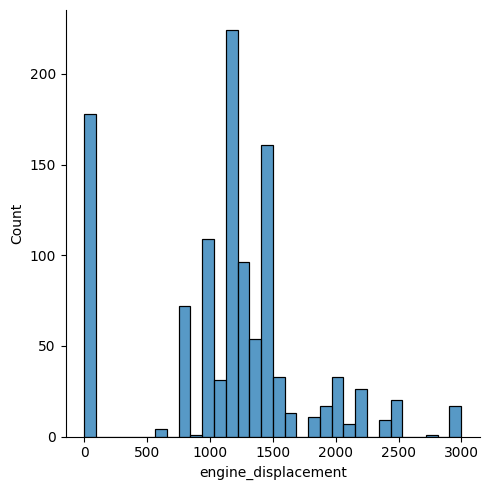

mean: 1159.2139659803045 median: 1198.0


In [30]:
sns.displot(df['engine_displacement'])
plt.show()
print('mean:',df['engine_displacement'].mean(),'median:',df['engine_displacement'].median())

In [31]:
df.fillna({'engine_displacement':df['engine_displacement'].median()},inplace=True)

### Engineering the 'Alloy Wheel Size' column 

In [32]:
df['alloy_wheel_size']=df['Alloy Wheel Size'].apply(lambda x:str(x).lower())
df['alloy_wheel_size'].value_counts()

alloy_wheel_size
nan    429
16     180
15     136
14     108
17      94
13      64
12      40
r16     22
18      19
r17      8
19       6
20       6
r15      5
r18      2
r14      1
Name: count, dtype: int64

In [33]:
al=[]
for i in list(df['alloy_wheel_size']):
    if i=='nan':
        al.append(np.nan)
    elif i[0]!='r':
        al.append(f'r{i}')
    else:
        al.append(i)
df['alloy_wheel_size']=al
df['alloy_wheel_size'].value_counts()

alloy_wheel_size
r16    202
r15    141
r14    109
r17    102
r13     64
r12     40
r18     21
r19      6
r20      6
Name: count, dtype: int64

In [34]:
df.fillna({'alloy_wheel_size':'r16'},inplace=True)

In [35]:
df['alloy_wheel_size'].isnull().sum()

0

### Engineering the 'Turbo Charger' column

In [36]:
df['turbo_charger']=df['Turbo Charger'].apply(lambda x:str(x).lower())
print(df['turbo_charger'].value_counts())

turbo_charger
no      528
yes     463
nan     125
twin      4
Name: count, dtype: int64


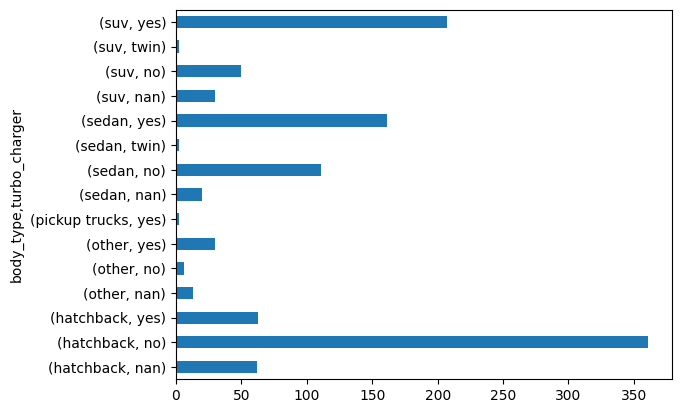

In [37]:
df.groupby(['body_type','turbo_charger'])['turbo_charger'].count().plot(kind='barh')
plt.show()

In [38]:
z=list(df[df['turbo_charger']=='nan']['body_type'])
z

['hatchback',
 'suv',
 'suv',
 'other',
 'sedan',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'sedan',
 'suv',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'other',
 'suv',
 'sedan',
 'suv',
 'hatchback',
 'hatchback',
 'hatchback',
 'suv',
 'suv',
 'suv',
 'hatchback',
 'hatchback',
 'suv',
 'hatchback',
 'sedan',
 'other',
 'suv',
 'hatchback',
 'hatchback',
 'hatchback',
 'suv',
 'hatchback',
 'hatchback',
 'suv',
 'suv',
 'suv',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'other',
 'hatchback',
 'sedan',
 'sedan',
 'hatchback',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'sedan',
 'hatchback',
 'suv',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'suv',
 'suv',
 'other',
 'suv',
 'sedan',
 'suv',
 'suv',
 'sedan',
 'hatchback',
 'sedan',
 'hatchback',
 'sedan',
 'hatchback',
 'suv',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 '

In [39]:
for h in range(len(z)):
    if z[h]=='suv' or z[h]=='other':
        df.loc[(df['body_type']==z[h]) & (df['turbo_charger'].isnull()),['turbo_charger']]='yes'
    elif z[h]=='hatchback' or z[h]=='sedan':
        df.loc[(df['body_type']==z[h]) & (df['turbo_charger'].isnull()),['turbo_charger']]='no'

In [40]:
df['turbo_charger'].isnull().sum()

0

### Engineering the 'Front Brake Type' column

In [41]:
df.columns

Index(['bt', 'owner', 'oem', 'Registration Year', 'Engine Displacement',
       'Seating Capacity', 'Alloy Wheel Size', 'Turbo Charger', 'Engine',
       'Front Brake Type', 'Gear Box', 'Height', 'Kerb Weight', 'Length',
       'Max Power', 'Max Torque', 'Mileage', 'Rear Brake Type', 'Wheel Base',
       'Width', 'kms', 'price_new', 'No Door Numbers', 'No of Cylinder',
       'Values per Cylinder', 'body_type', 'registration_year',
       'seating_capacity', 'engine_displacement', 'alloy_wheel_size',
       'turbo_charger'],
      dtype='object')

In [42]:
df['front_brake_type']=df['Front Brake Type'].apply(lambda x:str(x).lower())
print(df['front_brake_type'].value_counts())

front_brake_type
disc                                687
ventilated disc                     353
ventilated discs                     16
solid disc                           12
disc & caliper type                  12
nan                                  12
disc                                  5
ventilated disc                       5
vantilated disc                       3
ventilated disk                       3
disk                                  3
disc, 236 mm                          3
 disc                                 1
discs                                 1
multilateral disc                     1
ventlated disc                        1
booster assisted ventilated disc      1
drum                                  1
Name: count, dtype: int64


In [43]:
df['front_brake_type'].unique()

array(['disc', 'ventilated disc', 'disc ', 'ventilated discs',
       'solid disc', 'ventilated disc ', 'disc & caliper type',
       'vantilated disc', 'nan', 'multilateral disc', 'ventilated disk',
       'disk', 'disc, 236 mm', 'booster assisted ventilated disc',
       'ventlated disc', ' disc', 'discs', 'drum'], dtype=object)

In [44]:
df['front_brake_type']=df['front_brake_type'].map({'disc':'solid disc','ventilated disc':'ventilated discs',
                                                   'ventilated discs':'ventilated discs','disc ':'solid disc',
                                                   'solid disc':'solid disc','disk':'solid disc','ventilated disk':'ventilated discs',
                                                   'ventilated disc ':'ventilated discs','vantilated disc':'ventilated discs',
                                                   'ventlated disc':'ventilated discs','disc, 236 mm':'solid disc','nan':'solid disc',
                                                   'drum':'other','multilateral disc':'other','disc & caliper type':'other',
                                                   'booster assisted ventilated disc':'other','caliper ventilated disc':'other',
                                                   'abs':'other'})
print(df['front_brake_type'].value_counts())

front_brake_type
solid disc          722
ventilated discs    381
other                15
Name: count, dtype: int64


### Engineering the 'Gear Box' column

In [45]:
df['gear_box']=df['Gear Box'].apply(lambda x:str(x).lower())
print(df['gear_box'].value_counts())

gear_box
5 speed                                     686
6 speed                                     122
5-speed                                      67
6-speed                                      40
6 speed                                      33
7 speed                                      25
4 speed                                      24
8 speed                                      20
nan                                          17
5 speed                                      16
5                                            12
cvt                                          11
7-speed dct                                   7
9 speed                                       5
6-speed imt                                   4
6-speed ivt                                   3
6                                             2
5 speed cvt                                   2
five speed manual transmission                2
7-speed dsg                                   2
8-speed steptronic             

In [46]:
df['gear_box'].unique()

array(['6 speed', '5-speed', '5 speed ', '5 speed', '8-speed ', '4-speed',
       '8-speed steptronic', '8 speed', '6-speed ivt', '6-speed',
       '7 speed', '4 speed', '5', 'cvt', '7-speed s-tronic ', '6 speed ',
       '7-speed dsg', 'nan', '8 speed cvt', '7-speed dct', '6-speed cvt',
       '6-speed imt', '9 speed', 'five speed manual transmission gearbox',
       '5 speed cvt', '6', '7g dct 7-speed dual clutch transmission ',
       'single speed reduction gear', 'five speed manual transmission',
       '4 speed ', 'ivt', 'single speed', '8 speed sport', '8-speed',
       'imt', '5-speed`', '5 speed at+ paddle shifters'], dtype=object)

In [47]:
gb=[]
for i in list(df['gear_box']):
    if i=='5 speed' or i=='5-speed' or i=='5 speed ' or i=='5' or i=='five speed' :
        gb.append('5 speed')
    elif i=='five speed manual transmission gearbox' :
        gb.append('5 speed manual transmission')
    elif i=='five speed manual transmission':
        gb.append('5 speed manual transmission')
    elif i in ['7 speed ','7-speed']:
        gb.append('7 speed')
    elif i in ['7-speed stronic','7-speed s-tronic','7-speed s-tronic ']:
        gb.append('7-speed s-tronic')
    elif i in [ '7 speed dct','7-speed dct']:
        gb.append( '7 speed dct')
    elif i in ['8-speed','8', '8-speed ','8 speed ']:
        gb.append('8 speed')
    elif i in ['6 speed ','6-speed','6']:
        gb.append('6 speed')
    elif i in ['6-speed at','6-speed at' ,'6 speed at',]:
        gb.append('6-speed at')
    elif i in ['six speed manual',]:
        gb.append('6-speed manual') 
    else:
        gb.append(i)
        

In [48]:
df['gear_box']=gb
print(df['gear_box'].value_counts())

gear_box
5 speed                                     781
6 speed                                     197
7 speed                                      25
4 speed                                      24
8 speed                                      23
nan                                          17
cvt                                          11
7 speed dct                                   7
9 speed                                       5
6-speed imt                                   4
5 speed manual transmission                   3
6-speed ivt                                   3
5 speed cvt                                   2
7-speed dsg                                   2
8-speed steptronic                            2
4-speed                                       2
imt                                           1
ivt                                           1
5-speed`                                      1
8 speed sport                                 1
single speed                   

In [49]:
x=list(df['gear_box'])
gb1=['other' if x.count(i)<10 else i for i in x ]

In [50]:
df['gear_box']=gb1
print(df['gear_box'].value_counts())

gear_box
5 speed    781
6 speed    197
other       42
7 speed     25
4 speed     24
8 speed     23
nan         17
cvt         11
Name: count, dtype: int64


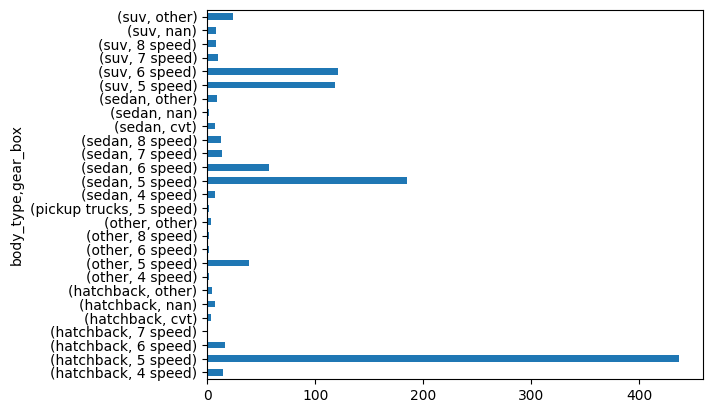

In [51]:
df.groupby(['body_type','gear_box'])['gear_box'].count().plot(kind='barh')
plt.show()

In [52]:
df.fillna({'gear_box':'5 speed'},inplace=True)

In [53]:
df['gear_box'].isnull().sum()

0

### Engineering the 'Mileage' column

In [54]:
df['mileage']=df['Mileage'].apply(lambda x:str(x).lower())
print(df['mileage'].value_counts())

mileage
18.9 kmpl     31
nan           28
17 kmpl       26
21.1 kmpl     24
19.7 kmpl     22
              ..
12.62 kmpl     1
22.5 kmpl      1
13.1 kmpl      1
25.83 kmpl     1
16.39 kmpl     1
Name: count, Length: 261, dtype: int64


In [55]:
avs=[]
for i in list(df['mileage']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b))))
df['mileage']=avs
df['mileage'].value_counts()

mileage
21.0    132
19.0    122
20.0    120
17.0    106
22.0    101
18.0     94
16.0     71
23.0     66
24.0     48
15.0     43
25.0     40
26.0     32
13.0     28
14.0     23
27.0     19
28.0     18
12.0     17
11.0      5
10.0      2
32.0      1
36.0      1
31.0      1
9.0       1
8.0       1
Name: count, dtype: int64

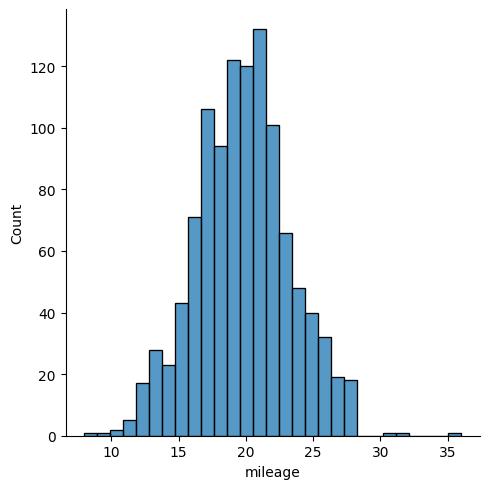

mean: 19.76831501831502 median: 20.0


In [56]:
sns.displot(df['mileage'])
plt.show()
print('mean:',df['mileage'].mean(),'median:',df['mileage'].median())

In [57]:
df.fillna({'mileage':df['mileage'].median()},inplace=True)

In [58]:
df['mileage'].isnull().sum()

0

### Engineering the 'Wheel Base' column

In [59]:
df['wheel_base' ]=df['Wheel Base' ].apply(lambda x:str(x).lower())
print(df['wheel_base' ].value_counts())

wheel_base
2360mm    72
2600mm    49
2380mm    48
2450mm    42
2425mm    41
          ..
2460mm     1
2670mm     1
2553mm     1
3014       1
2445       1
Name: count, Length: 151, dtype: int64


In [60]:
avs=[]
for i in list(df['wheel_base']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b))))
df['wheel_base']=avs
df['wheel_base'].value_counts()

wheel_base
2360.0    82
2450.0    79
2600.0    56
2500.0    54
2380.0    52
          ..
2864.0     1
2460.0     1
2968.0     1
3014.0     1
2445.0     1
Name: count, Length: 110, dtype: int64

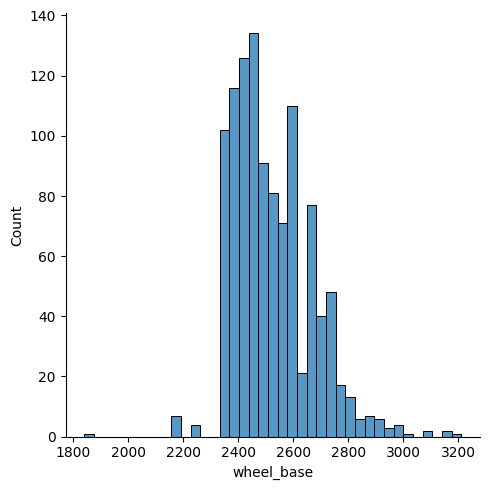

mean: 2525.1127406049495 median: 2500.0


In [61]:
sns.displot(df['wheel_base'])
plt.show()
print('mean:',df['wheel_base'].mean(),'median:',df['wheel_base'].median())

In [62]:
df.fillna({'wheel_base':df['wheel_base'].median()},inplace=True)

In [63]:
df['wheel_base'].isnull().sum()

0

### Engineering the 'Height' column

In [64]:
df['height' ]=df['Height'].apply(lambda x:str(x).lower())
print(df['height'].value_counts())

height
1475mm    55
1530mm    48
1505mm    46
1520mm    41
1640mm    39
          ..
1669       1
1855       1
1508mm     1
1786mm     1
1615       1
Name: count, Length: 188, dtype: int64


In [65]:
avs=[]
for i in list(df['height']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['height']=avs
df['height'].value_counts()

height
1475.0    65
1530.0    61
1505.0    57
1520.0    55
1640.0    40
          ..
1585.0     1
1433.0     1
1522.0     1
1467.0     1
1615.0     1
Name: count, Length: 142, dtype: int64

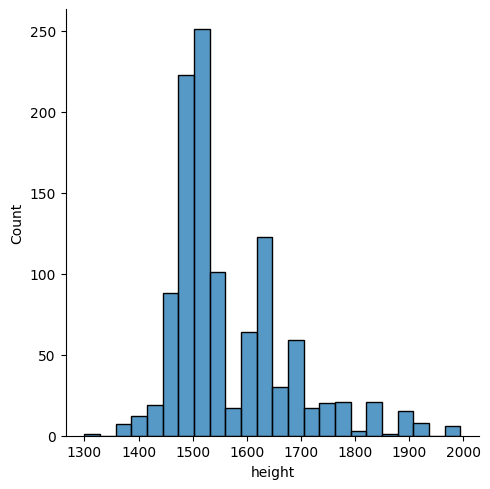

mean: 1567.79945799458 median: 1530.0


In [66]:
sns.displot(df['height'])
plt.show()
print('mean:',df['height'].mean(),'median:',df['height'].median())

In [67]:
df.fillna({'height':df['height'].median()},inplace=True)

### Engineering the 'Kerb Weight' column

In [68]:
df['kerb_weight' ]=df['Kerb Weight'].apply(lambda x:str(x).lower())
print(df['kerb_weight'].value_counts())
df['kerb_weight'].unique()

kerb_weight
705kg      18
935kg      17
1055kg     17
885kg      17
880        14
           ..
860         1
1579kg      1
1312        1
2001kg      1
1290kgs     1
Name: count, Length: 376, dtype: int64


array(['1515kg', '875-905', '840kg', '1100', '890kg', '1173kg', '1608kg',
       '1485', '1140', '1155kg', '990', '1660', '1,965', '1565kg',
       '1045kg', '1490', '1435', '1355', '1069kg', '1280', '1020kg',
       '865-890', '1042kg', '1039kg', '955-990kg', '720kg', '1600kg',
       '1799kg', '2010', '1040', '970kg', '1190kg', '1012', '1570',
       '600kg', '855-885', '910', '1125kg', '830-845kg', '1450', '935kg',
       '920kg', '1130-1170', '1055kg', '1660kg', '925kg', '1260',
       '1180kg', '870kg', '1650 kgs', '1107-1153kg', '1252kg', '1063',
       '1680kg', '1820', '1220kg', '1540', '1700', '1685', '1105kg',
       '1160-1215kg', '1170kg', '1302kg', '1540kg', '810', '1044kg',
       '1562 kgs', '845', '1225', '1545kg', '1376kg', '920-955', '1060',
       '1260kg', '1165kg', '1505', '1330', '1300', '1670', '1240', '982',
       '1625', '705kg', '1066 kg', '1290kg', '1084kg', '1050', '750',
       '1103kg', '1200kg', '885kg', '1230kg', '1147kg', '1551 kgs',
       '1115kg', '

In [69]:
avs=[]
for i in list(df['kerb_weight']):
    if i=='nan' or i=='kerb weight':
        avs.append(np.nan)
    
    elif i[0].isnumeric()==True:
        
        b=[]
        if '-' in list(i):
            r=i.index('-')
            for k in range(r):
                if i[k].isnumeric()==True or i[k]=='.':
                    b.append(i[k])
        else:   
            for j in i:
                    if j.isnumeric()==True or j=='.':
                        b.append(j)
        
        avs.append(round(float(''.join(b))))
df['kerb_weight']=avs
df['kerb_weight'].value_counts()

kerb_weight
880.0     27
1100.0    24
1050.0    20
860.0     19
705.0     18
          ..
820.0      1
1945.0     1
1879.0     1
1023.0     1
1245.0     1
Name: count, Length: 275, dtype: int64

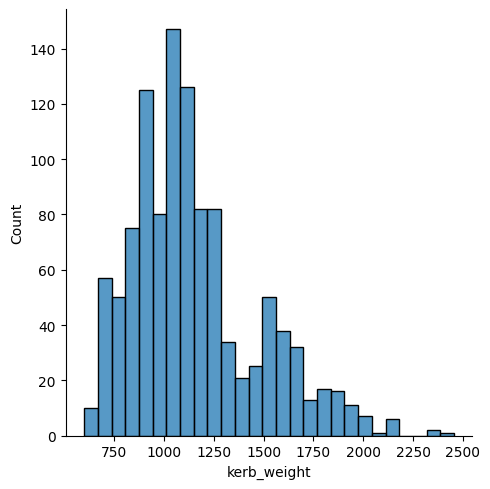

mean: 1150.0920577617328 median: 1097.5


In [70]:
sns.displot(df['kerb_weight'])
plt.show()
print('mean:',df['kerb_weight'].mean(),'median:',df['kerb_weight'].median())

In [71]:
df.fillna({'kerb_weight':df['kerb_weight'].median()},inplace=True)

### Engineering the 'Length' column

In [72]:
df['length' ]=df['Length'].apply(lambda x:str(x).lower())
print(df['length'].value_counts())
df['length'].unique()

length
3995mm    166
3495mm     45
4440mm     34
3765mm     34
4315mm     29
         ... 
4490        1
4648mm      1
4000mm      1
5295mm      1
3827mm      1
Name: count, Length: 204, dtype: int64


array(['3985mm', '3845mm', '3715mm', '3765mm', '3599mm', '4310mm',
       '3995mm', '4838mm', '4477mm', '3585mm', '4936mm', '5238mm',
       '4861mm', '4300mm', '3995 mm', '3993', '4598mm', '4270mm',
       '3970mm', '4440mm', '3430mm', '4841mm', '4697mm', '4886mm',
       '4384mm', '3991mm', '4447mm', '3099 mm', '3840mm', '3495mm',
       '3655 mm', '4300', '4385mm', '3610mm', '4370mm', '4250mm',
       '4445mm', '3595mm', '4585 mm', '4549mm', '3994mm', '3989mm',
       '4585mm', '5255mm', '4315mm', '4160mm', '4541mm', '4490mm',
       '3998mm', '3695mm', '3955mm', '4395mm', '3515mm', '3565mm',
       '4597mm', '3990mm', '4670mm', '4296mm', '4716', '3955 mm',
       '3999mm', '3610 mm', '3429mm', '3995', '4221mm', '4225mm',
       '4,580 mm', '4430mm', '4755mm', '4817mm', '4695 mm', '3731mm',
       '3941 mm', '3445', '4456mm', '4375mm', '4637mm', '4413mm', 'nan',
       '4323mm', '4540mm', '3679mm', '4249mm', '3545mm', '4720mm',
       '4630mm', '4490', '4648mm', '4425mm', '4490 mm',

In [73]:
avs=[]
for i in list(df['length']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['length']=avs
df['length'].value_counts()

length
3995.0    179
3495.0     45
3765.0     35
4440.0     34
4315.0     30
         ... 
3880.0      1
4749.0      1
4892.0      1
4017.0      1
3827.0      1
Name: count, Length: 174, dtype: int64

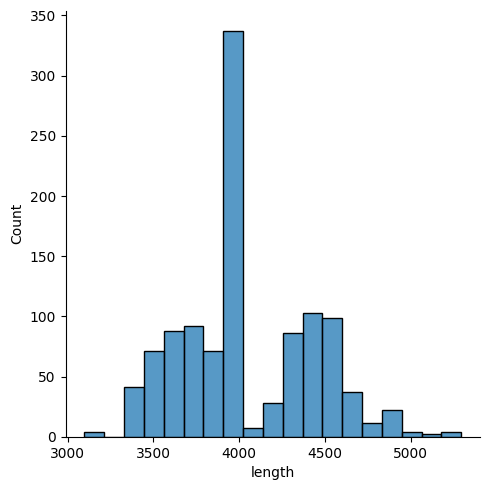

mean: 4050.972899728997 median: 3995.0


In [74]:
sns.displot(df['length'])
plt.show()
print('mean:',df['length'].mean(),'median:',df['length'].median())

In [75]:
df.fillna({'length':df['length'].median()},inplace=True)

### Engineering the 'Max Power' column

In [76]:
df['max_power']=df['Max Power'].apply(lambda x:str(x).lower())
print(df['max_power'].value_counts())
df['max_power'].unique()

max_power
74bhp        54
88.50bhp     33
88.5bhp      28
98.6bhp      28
81.86bhp     27
             ..
107.3bhp      1
70            1
138.03bhp     1
177           1
86.63bhp      1
Name: count, Length: 235, dtype: int64


array(['88.73bhp', '88.50bhp', '67.04bhp', '81.86bhp', '67bhp', '110 ',
       '82bhp', '138.1bhp', '184bhp', '88.76bhp', '74bhp', '78.9bhp',
       '187.74bhp', '261.49bhp', '174.5bhp', '113.18bhp', '110bhp',
       '118.35bhp', '167.67bhp', '73.75bhp', '126.2bhp', '73.9bhp',
       '81.80bhp', '117.3bhp', '74.02bhp', '47.3bhp', '177 ', '148bhp',
       '258bhp', '82.85bhp', '103.6bhp', '71.01bhp', '189.08bhp',
       '35 bhp', '55.2bhp', '108.62bhp', '83.1bhp', '103.25bhp', '62bhp',
       '174.33bhp', '86.8bhp', '126.32bhp', '93.7bhp', '103.2bhp',
       '121bhp', '119.35bhp', '108.5bhp', '88.5bhp', '100bhp',
       '301.73bhp', '113.43bhp', '140bhp', '113.98bhp', '103.3bhp',
       '98.96bhp', '177.46bhp', '65.71bhp', '88.7bhp', '170.63bhp',
       '68.05bhp', '62.1bhp', '98.63bhp', '163.7bhp', '98.6bhp', '178bhp',
       '100.6bhp', '113.42bhp', '355.37bhp', '84.82bhp', '113.45bhp',
       '46.3bhp', '89.84bhp', '97.9bhp', '170bhp', '101.65bhp',
       '147.51bhp', '117.6bhp', '91

In [77]:
a=[]
for i in list(df['max_power']):
    if 'bhp' not in i:
        a.append(i)
print(set(a))

{'102', '63 hp at 3200 rpm', '66.6 ', '85 ps ', '90ps at 4000rpm', '171 ps ', '103.2 ps at 5500 rpm', '78 ', '83 ps ', '177 ', '64', '90 ps', '88.2', '118ps at 6,600 rpm', '104.68', '75 ps at 4000  rpm ', '105ps ', 'nan', '75 ps ', '105 ', '110 ', '70', '84.5', '57.5', '106', '90(66) ', '144 ', '80 ps at 5200 rpm', '60 ps ', '94 ', '63 '}


In [78]:
avs=[]
for i in list(df['max_power']):
    if i=='nan':
        avs.append(np.nan)
    elif i=='66(90) / 4000' or i=='90(66) ':
        avs.append(65)
    elif i=='118ps at 6,600 rpm':
        avs.append(116.39)
    elif i=='105 ps at 5250 rpm':
        avs.append(103.56)
    elif i=='90ps at 4000rpm':
        avs.append(78.91)
    elif i=='80 ps at 5200 rpm':
        avs.append(99.77)
    elif i=='63 hp at 3200 rpm':
        avs.append(63)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['max_power']=avs
df['max_power'].value_counts()

max_power
74.0      87
67.0      84
82.0      74
88.0      67
89.0      46
          ..
104.0      1
189.0      1
204.0      1
7554.0     1
65.0       1
Name: count, Length: 111, dtype: int64

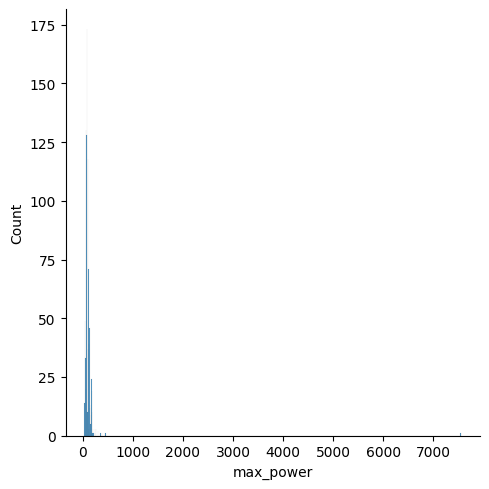

mean: 109.59484248424843 median: 88.0


In [79]:
sns.displot(df['max_power'])
plt.show()
print('mean:',df['max_power'].mean(),'median:',df['max_power'].median())

In [80]:
df.fillna({'max_power':df['max_power'].median()},inplace=True)

### Engineering the 'Max Torque' column

In [81]:
df['max_torque' ]=df['Max Torque'].apply(lambda x:str(x).lower())
print(df['max_torque' ].value_counts())
df['max_torque' ].unique()

max_torque
190nm@2000rpm          65
200nm@1750rpm          64
90nm@3500rpm           60
69nm@3500rpm           27
110nm@4800rpm          27
                       ..
190nm@4200rpm           1
88.4nm@4200rpm          1
215nm@1750-3000rpm      1
360nm@1400-3200rpm      1
115nm@3250+/-100rpm     1
Name: count, Length: 239, dtype: int64


array(['219.7nm@1500-2750rpm', '113nm@4400rpm', '90nm@3500rpm',
       '113.75nm@4000rpm', '24 @ 1,900-2,750 (kgm@rpm)', '114nm@4000rpm',
       '320nm@1750-2500rpm', '380nm@1750-2750rpm', '219.6nm@1750-2750rpm',
       '190nm@1750-3000rpm', '111.8nm@4000rpm', '400nm@1750-2500rpm',
       '620nm@2000-2500rpm', '350nm@1500-3500rpm', '190nm@2000rpm',
       '143.8nm@4500rpm', '200nm@2000-3500rpm', '170nm@1750-4000rpm',
       '350nm@1750-2500rpm', '110nm@3750rpm', '259.9nm@1900-2750rpm',
       '113nm@4200rpm', '145nm@4600rpm', '160nm@1750rpm', '69nm@3500rpm',
       '35.7 @ 1,750-3,000 (kgm@rpm)', '340nm@1750-3000rpm',
       '560nm@1500-3000rpm', '113.7nm@4000rpm', '250nm@1500-2500rpm',
       '96nm@3500rpm', '280nm@1350-4600rpm', '4.8 kgm@3000 rpm',
       '74.5nm@4000rpm', '180nm@2000rpm', '115nm@4000rpm',
       '138nm@4400rpm', '90.3nm@4200rpm', '380nm@1750-2500rpm',
       '109nm@4500rpm', '259.8nm@1900-2750rpm', '124.5nm@3500rpm',
       '84nm@3500rpm', '114.73nm@4000rpm', '300nm

In [82]:
s=[i if '15' in i else 'a' for i in list(df['max_torque'])]
s

['219.7nm@1500-2750rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '350nm@1500-3500rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '560nm@1500-3000rpm',
 'a',
 'a',
 '250nm@1500-2500rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '115nm@4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '115nm@4000rpm',
 'a',
 'a',
 'a',
 '250nm@1500-2750rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '215nm@1750-2500rpm',
 '115nm@4000rpm',
 '115nm@4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '240nm@1500-2750rpm',
 'a',
 '250nm@1500-2500rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '260nm@1500-2750rpm',
 'a',
 'a',
 'a',
 '219.7nm@1500-2750rpm',
 'a',
 '250nm@1500-2500rpm',
 '250nm@1500-2750rpm',
 'a',
 'a',
 'a',
 '219.7nm@1500-2750rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '115nm@4000rpm',
 'a',

In [83]:
avs=[]
for i in list(df['max_torque']):
    if i=='nan' :
        avs.append(np.nan)
    elif i=='11.4 kgm at 4,000 rpm':
        avs.append(round(111.79581))
    elif i=='22.4 kgm at 1750-2750rpm':
        avs.append(round(219.67))
    elif i=='13.5 kgm @ 4700 rpm':
        avs.append(round(132.38))
    elif i=='180 nm at 1440-1500rpm':
        avs.append(round(180))
    elif i=='13.5 kgm @ 4700 rpm':
        avs.append(round(219.87))
    elif i=='155 nm at 1600-2800 rpm':
        avs.append(round(155))  
    elif i=='210 / 1900':
        avs.append(round(210)) 
    elif i=='135 nm @ 2500 rpm ':
        avs.append(round(135)) 
    elif i=='148  nm @ 3500  rpm':
        avs.append(round(148))
    elif i=='146nm at 4800 rpm':
        avs.append(round(146))
    
    elif i[0].isnumeric()==True:
        b=[]
        if '@' in list(i):
            r=i.index('@')
            for k in range(r):
                if i[k].isnumeric()==True or i[k]=='.':
                    b.append(i[k])
        else:   
            for j in i:
                    if j.isnumeric()==True or j=='.':
                        b.append(j)
        
        avs.append(round(float(''.join(b))))
df['max_torque']=avs
df['max_torque'].value_counts()

max_torque
200.0        86
190.0        76
90.0         63
113.0        58
114.0        55
             ..
60.0          1
436.0         1
8.0           1
1901750.0     1
134.0         1
Name: count, Length: 122, dtype: int64

In [84]:
max(avs)

1901750

In [85]:
# sns.displot(df['max_torque'])
# plt.show()
print('mean:',df['max_torque'].mean(),'median:',df['max_torque'].median())

mean: 2885.5670567056704 median: 145.0


In [86]:
df.fillna({'max_torque':df['max_torque'].median()},inplace=True)

### Engineering the 'Width' column

In [87]:
df['width' ]=df['Width'].apply(lambda x:str(x).lower())
print(df['width'].value_counts())
df['width'].unique()

width
1695mm    93
1660mm    40
1680mm    39
1745mm    38
1475mm    38
          ..
1965mm     1
1880mm     1
1670       1
2047mm     1
1742       1
Name: count, Length: 165, dtype: int64


array(['1734mm', '1735', '1635mm', '1660mm', '1495mm', '1695mm', '1817mm',
       '2058mm', '1710mm', '1706mm', '1595mm', '2126mm', '1902mm',
       '1864mm', '1790mm', '1821 mm', '1811', '1894mm', '1682mm',
       '1780mm', '1745mm', '1735mm', '1490mm', '1846mm', '1882mm',
       '1938mm', '1699mm', '1750', '2060mm', '1495 mm', '1550mm',
       '1620 mm', '1821mm', '1785', '2019mm', '1680mm', '1700mm',
       '1670mm', '1775mm', '1475mm', '1866 mm', '1748mm', '1811mm',
       '1694', '1760mm', '2105mm', '1785mm', '1800mm', '1890mm', '1690mm',
       '1752mm', '1765mm', '1655', '1694mm', '1818mm', '1525mm', '1790',
       '1788mm', '1814mm', '1745', '1795mm', '1897', '1677', '1694 mm',
       '1645 mm', '1560mm', '1730mm', '1600mm', '1,770 mm', '2141mm',
       '1840 mm', '1835mm', '1579', '1704 mm', '1515', '1579mm', '2097mm',
       '1703mm', '1960mm', 'nan', '1809mm', '1739', '1777 mm', '1730',
       '2098mm', '1730 mm', '2031mm', '1769 mm', '1820mm', '2212 mm',
       '2089mm', '1

In [88]:
avs=[]
for i in list(df['width']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['width']=avs
df['width'].value_counts()

width
1695.0    99
1735.0    59
1680.0    51
1745.0    41
1475.0    40
          ..
1882.0     1
1880.0     1
2047.0     1
2212.0     1
1742.0     1
Name: count, Length: 125, dtype: int64

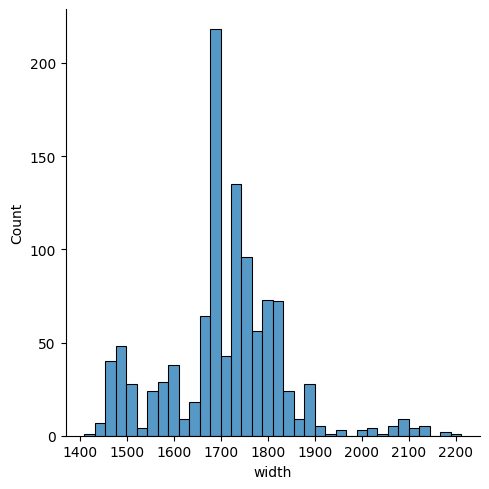

mean: 1709.8681120144536 median: 1710.0


In [89]:
sns.displot(df['width'])
plt.show()
print('mean:',df['width'].mean(),'median:',df['width'].median())

In [90]:
df.fillna({'width':df['width'].median()},inplace=True)

In [91]:
df.head()

,bt,owner,oem,Registration Year,Engine Displacement,Seating Capacity,Alloy Wheel Size,Turbo Charger,Engine,Front Brake Type,...,front_brake_type,gear_box,mileage,wheel_base,height,kerb_weight,length,max_power,max_torque,width
0,Hatchback,2_owners,hyundai,2015,1396 cc,5.0,16,Yes,1396 CC,Disc,...,solid disc,6 speed,23.0,2570.0,1505.0,1515.0,3985.0,89.0,220.0,1734.0
1,Hatchback,1_owner,maruti,Jan 2012,1197 cc,5.0,NaN,NaN,1197 CC,Disc,...,solid disc,5 speed,22.0,2450.0,1530.0,875.0,3845.0,88.0,113.0,1735.0
2,Hatchback,2_owners,maruti,2016,998 cc,5.0,NaN,No,998 CC,Ventilated Disc,...,ventilated discs,5 speed,23.0,2425.0,1565.0,840.0,3715.0,67.0,90.0,1635.0
3,Hatchback,1_owner,hyundai,Apr 2017,1197 cc,5.0,NaN,No,1197 CC,Disc,...,solid disc,5 speed,19.0,2425.0,1520.0,1100.0,3765.0,82.0,114.0,1660.0
4,Hatchback,1_owner,maruti,2016,998 cc,5.0,NaN,No,998 CC,Ventilated Disc,...,ventilated discs,5 speed,21.0,2400.0,1700.0,890.0,3599.0,67.0,90.0,1495.0


### Checking for null values on the newly engineered columns

In [92]:
pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})

,dtypes,null_count,unique_values,percent_of_null_values
bt,object,0,7,0.000000
owner,object,0,4,0.000000
oem,object,0,17,0.000000
Registration Year,object,0,179,0.000000
Engine Displacement,object,3,71,0.002679
Seating Capacity,float64,1,6,0.000893
Alloy Wheel Size,object,429,14,0.383036
Turbo Charger,object,125,5,0.111607
Engine,object,0,81,0.000000
Front Brake Type,object,12,19,0.010714


In [93]:
df.dropna(subset=['front_brake_type','Rear Brake Type','No of Cylinder','Values per Cylinder'],inplace=True)

These two columns namely 'No of Cylinder','Values per Cylinder' has null values ,so I'm dropping the rows considering these two columns as subset in the entire dataframe

In [94]:
pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})


,dtypes,null_count,unique_values,percent_of_null_values
bt,object,0,7,0.000000
owner,object,0,3,0.000000
oem,object,0,16,0.000000
Registration Year,object,0,174,0.000000
Engine Displacement,object,1,68,0.000910
Seating Capacity,float64,0,6,0.000000
Alloy Wheel Size,object,425,14,0.386715
Turbo Charger,object,108,5,0.098271
Engine,object,0,76,0.000000
Front Brake Type,object,0,17,0.000000


In [95]:
new_all_selected_features=['owner', 'oem','body_type', 'registration_year', 
    'alloy_wheel_size', 'turbo_charger', 'front_brake_type', 'gear_box',
   'Rear Brake Type','seating_capacity','kms', 'price_new', 'engine_displacement', 'mileage', 'wheel_base',
   'height', 'kerb_weight', 'length', 'max_power', 'max_torque','width']
for i in car_features:
    new_all_selected_features.append(i)

In [96]:
df=df[new_all_selected_features]
df.head()

,owner,oem,body_type,registration_year,alloy_wheel_size,turbo_charger,front_brake_type,gear_box,Rear Brake Type,seating_capacity,...,wheel_base,height,kerb_weight,length,max_power,max_torque,width,No Door Numbers,No of Cylinder,Values per Cylinder
0,2_owners,hyundai,hatchback,2015,r16,yes,solid disc,6 speed,Drum,5,...,2570.0,1505.0,1515.0,3985.0,89.0,220.0,1734.0,5.0,4.0,4.0
1,1_owner,maruti,hatchback,2012,r16,nan,solid disc,5 speed,Drum,5,...,2450.0,1530.0,875.0,3845.0,88.0,113.0,1735.0,5.0,4.0,4.0
2,2_owners,maruti,hatchback,2016,r16,no,ventilated discs,5 speed,Drum,5,...,2425.0,1565.0,840.0,3715.0,67.0,90.0,1635.0,5.0,3.0,4.0
3,1_owner,hyundai,hatchback,2017,r16,no,solid disc,5 speed,Drum,5,...,2425.0,1520.0,1100.0,3765.0,82.0,114.0,1660.0,5.0,4.0,4.0
4,1_owner,maruti,hatchback,2016,r16,no,ventilated discs,5 speed,Drum,5,...,2400.0,1700.0,890.0,3599.0,67.0,90.0,1495.0,5.0,3.0,4.0


In [97]:
#categorical columns list
cc=[]
#numerical columns list
nc=[]
for i in df.columns:
    if df[i].dtype=='O':
        cc.append(i)
    else:
        nc.append(i)
print('categorical_columns:',cc)
print()
print('numerical_columns:',nc)

categorical_columns: ['owner', 'oem', 'body_type', 'registration_year', 'alloy_wheel_size', 'turbo_charger', 'front_brake_type', 'gear_box', 'Rear Brake Type', 'seating_capacity']

numerical_columns: ['kms', 'price_new', 'engine_displacement', 'mileage', 'wheel_base', 'height', 'kerb_weight', 'length', 'max_power', 'max_torque', 'width', 'No Door Numbers', 'No of Cylinder', 'Values per Cylinder']


### Finding outliers in categorical columns and replacing it with upper and lower limit values respectively

In [98]:
def plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

   # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.show()

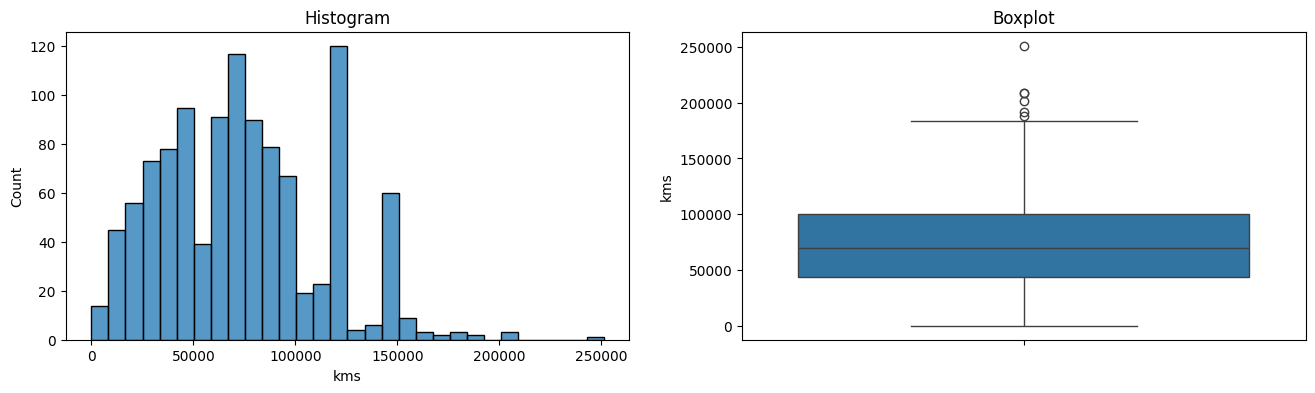

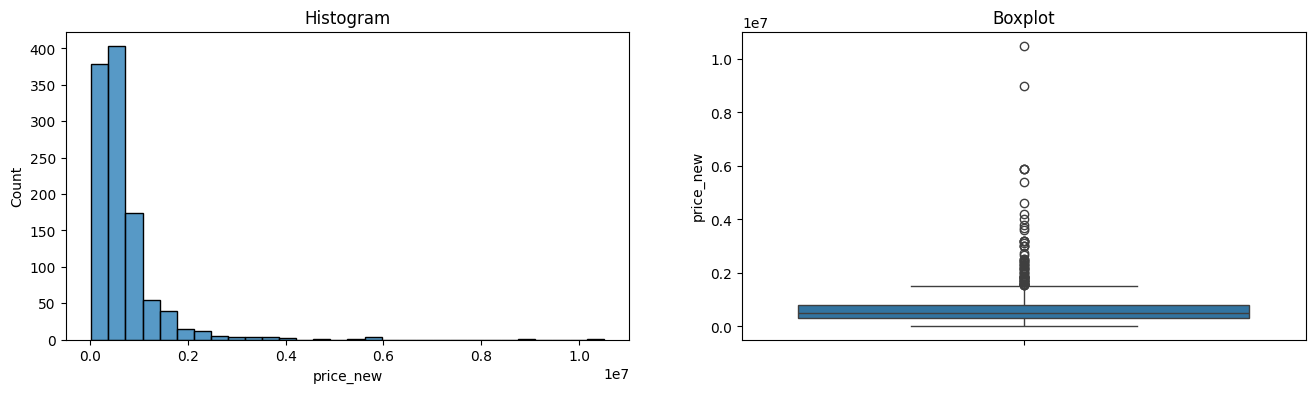

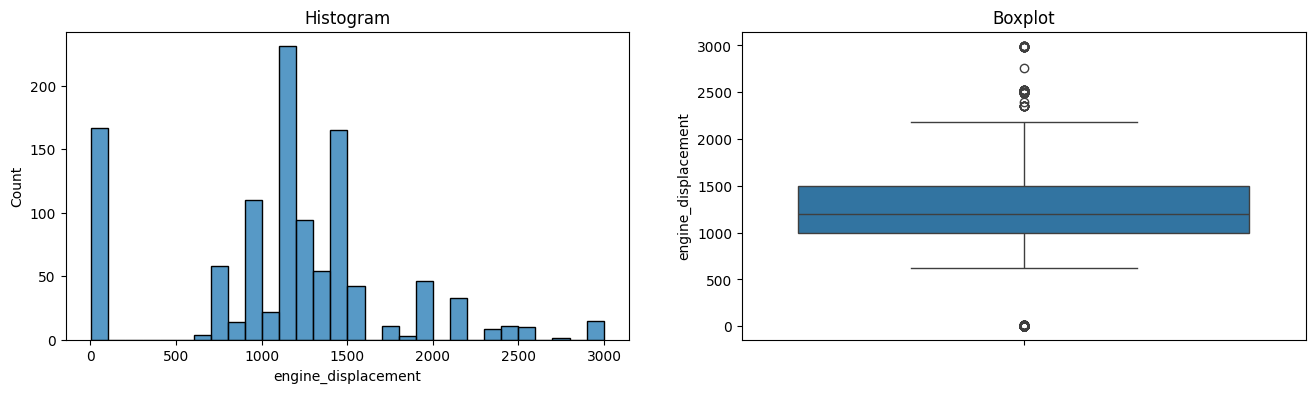

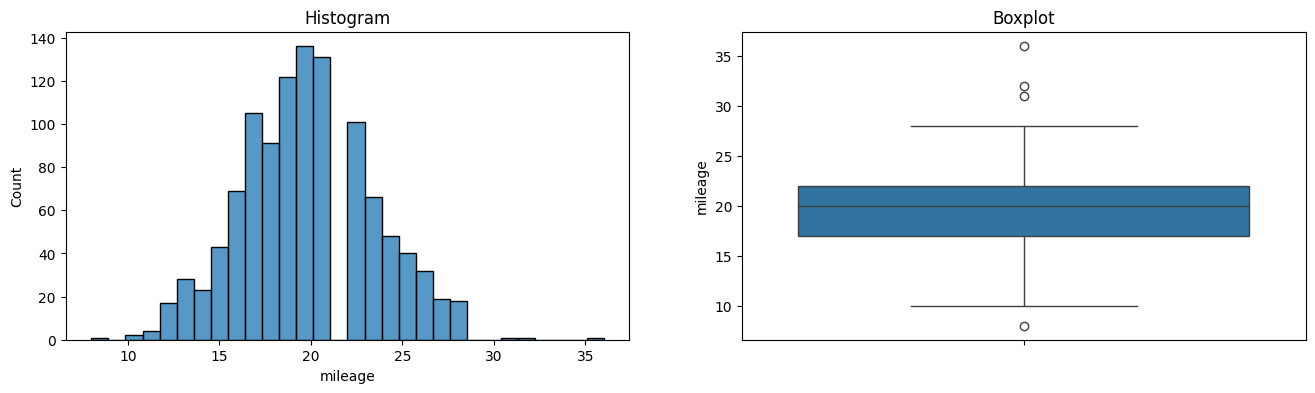

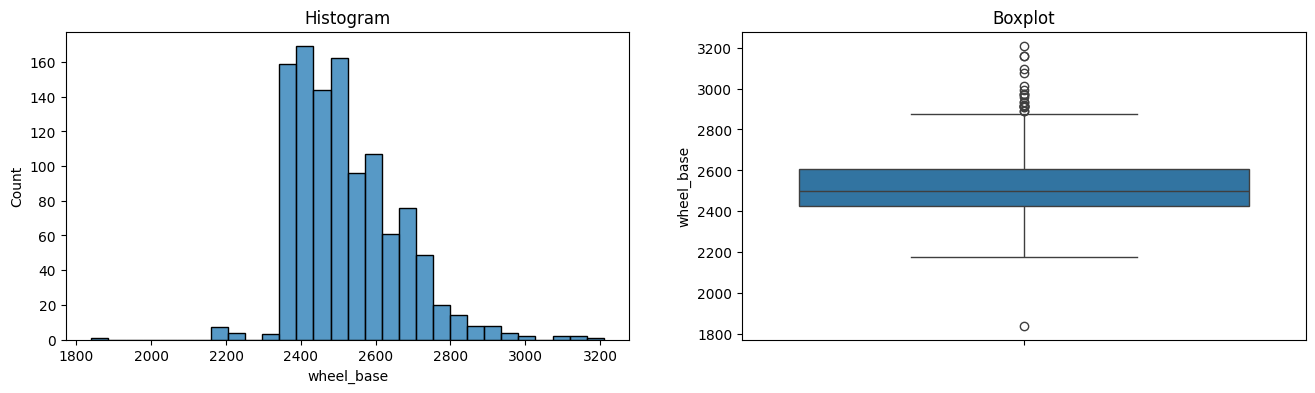

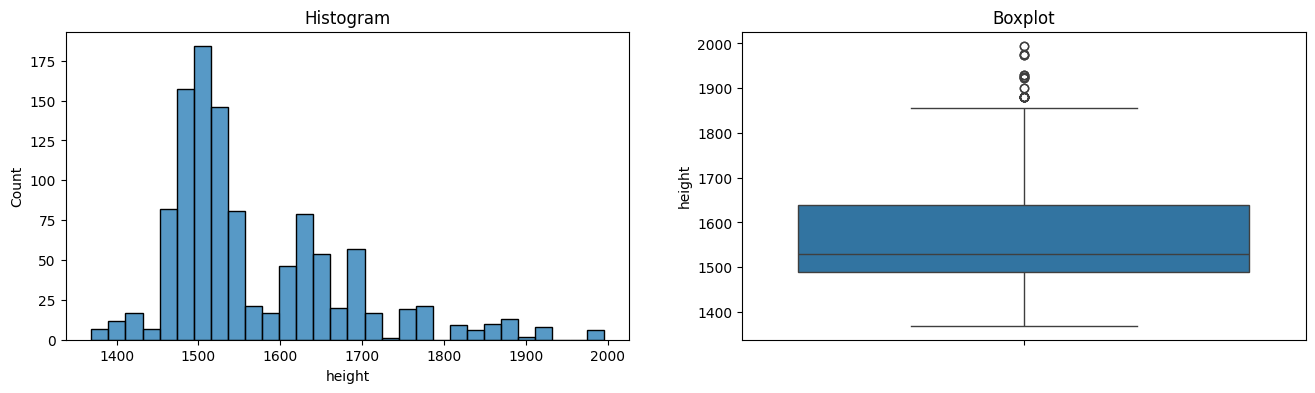

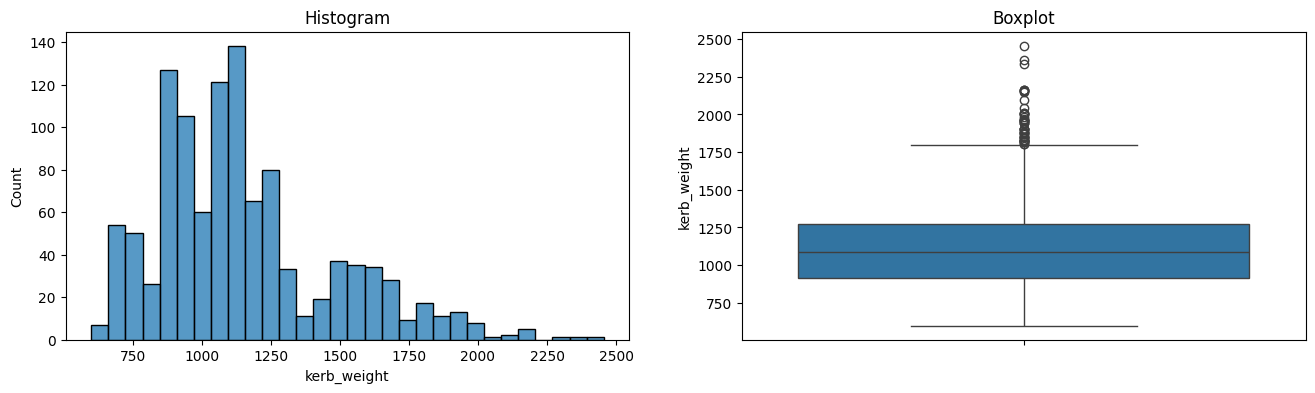

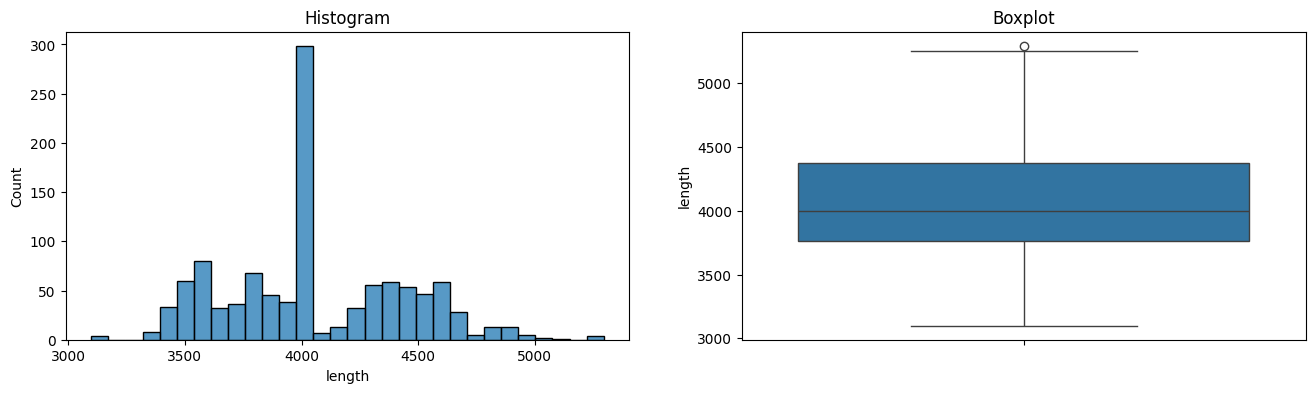

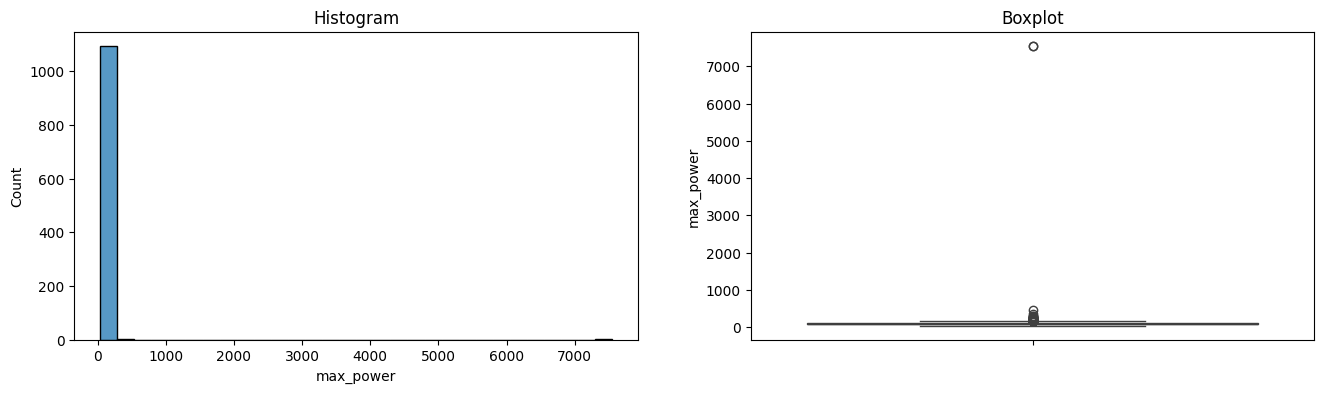

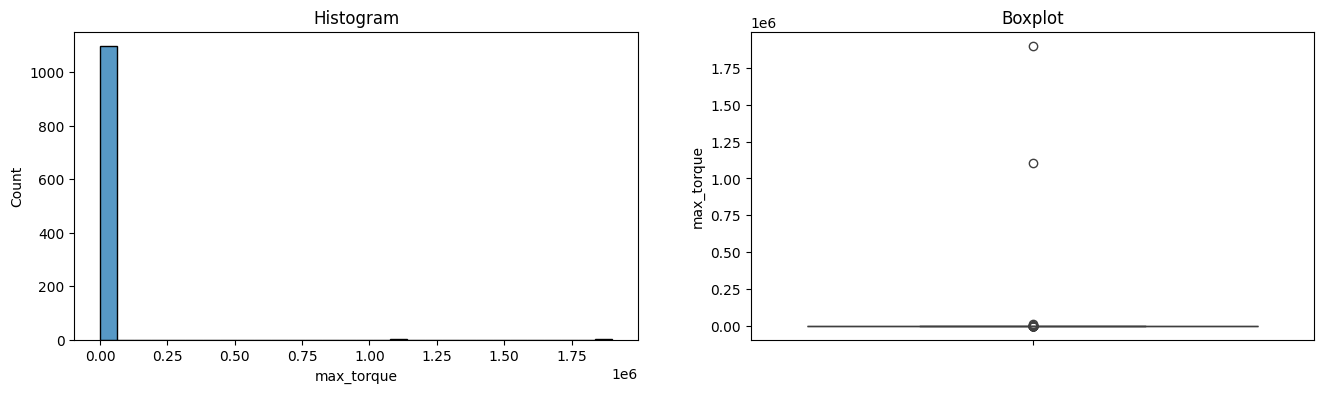

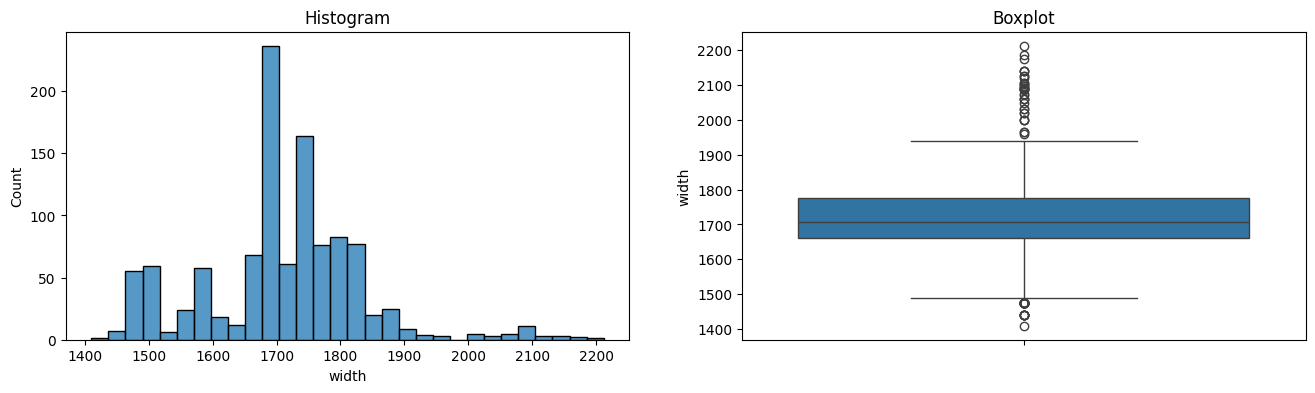

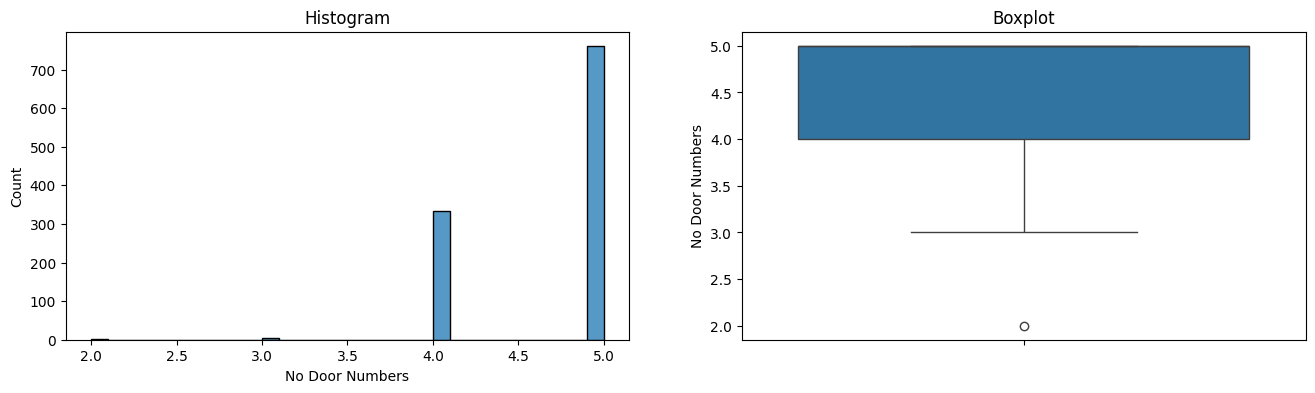

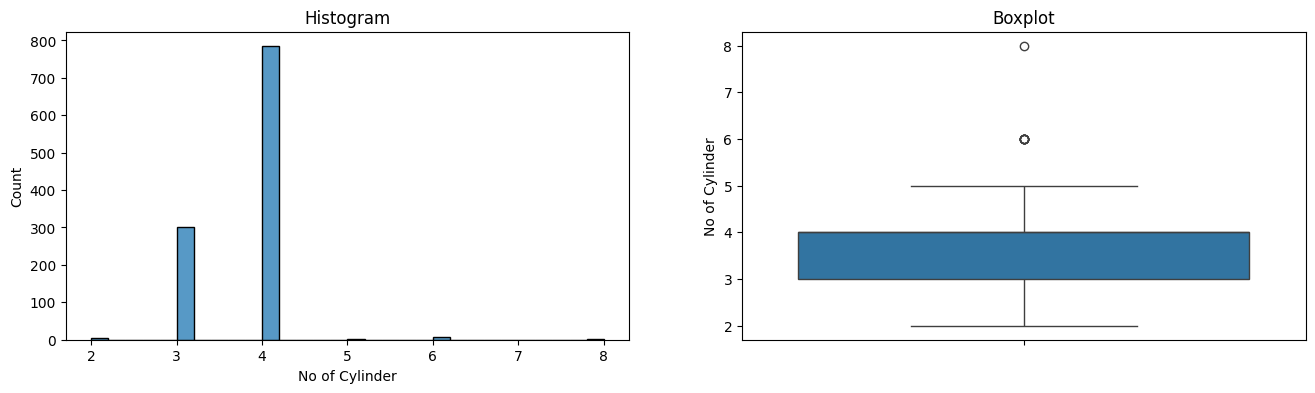

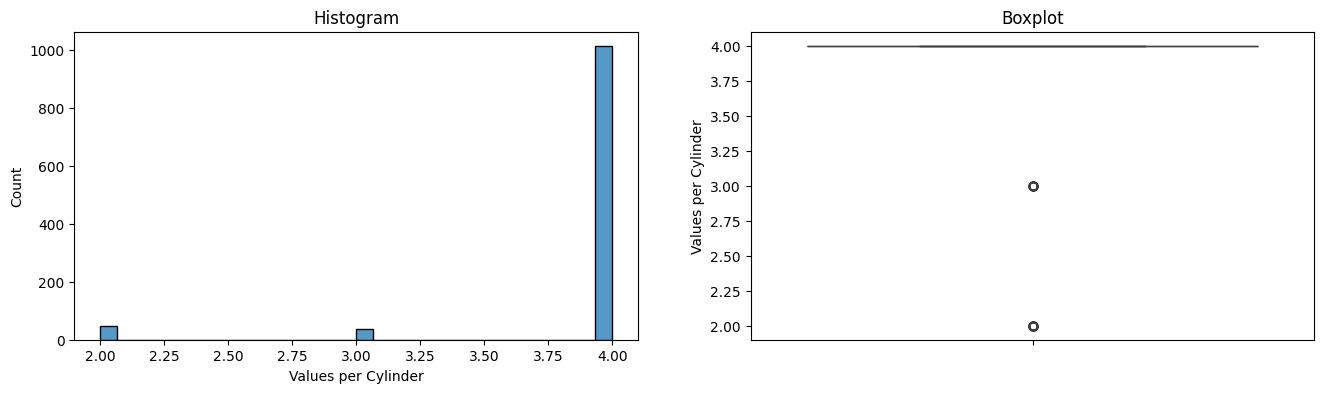

In [99]:
for m in nc:
    plots(df, m)

In [100]:
def find_skewed_boundaries(df, variable, distance):

    # Calculating the boundaries outside which sit the outliers
    # for skewed distributions


    IQR = round(df[variable].quantile(0.75) - df[variable].quantile(0.25))

    lower_boundary = abs(round(df[variable].quantile(0.25) - (IQR * distance)))
    upper_boundary = abs(round(df[variable].quantile(0.75) + (IQR * distance)))

    return upper_boundary, lower_boundary

In [101]:
ul=[]
for v in nc:
    upper_limit, lower_limit = find_skewed_boundaries(df, v, 1.5)
    ul.append((v,upper_limit, lower_limit))

In [102]:
def replace_outlier(dataset,variable,upper_limit,lower_limit):
    dataset[variable]= np.where(dataset[variable] > upper_limit, upper_limit,
                       np.where(dataset[variable] < lower_limit, lower_limit, dataset[variable]))

In [103]:
for v1 in range(len(ul)):
    replace_outlier(df,ul[v1][0],ul[v1][1],ul[v1][2])

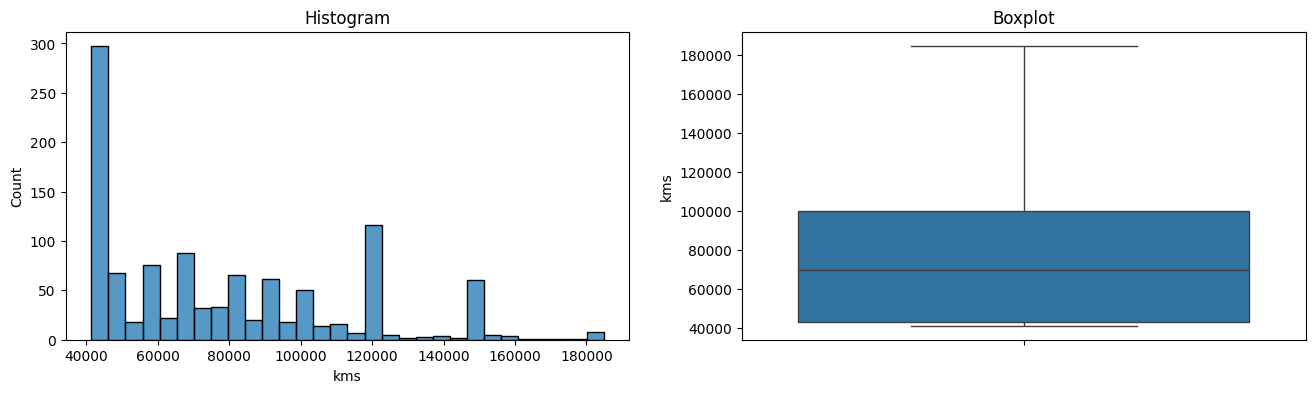

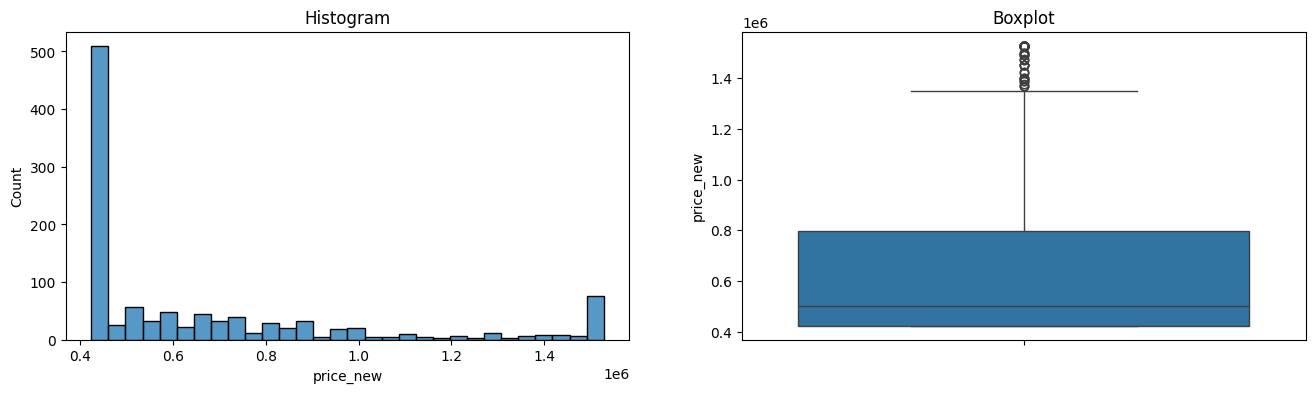

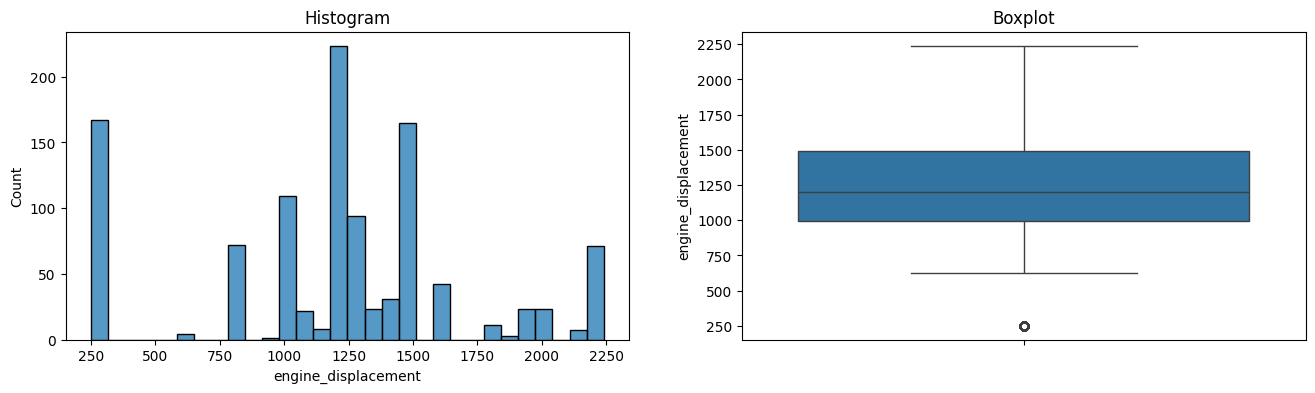

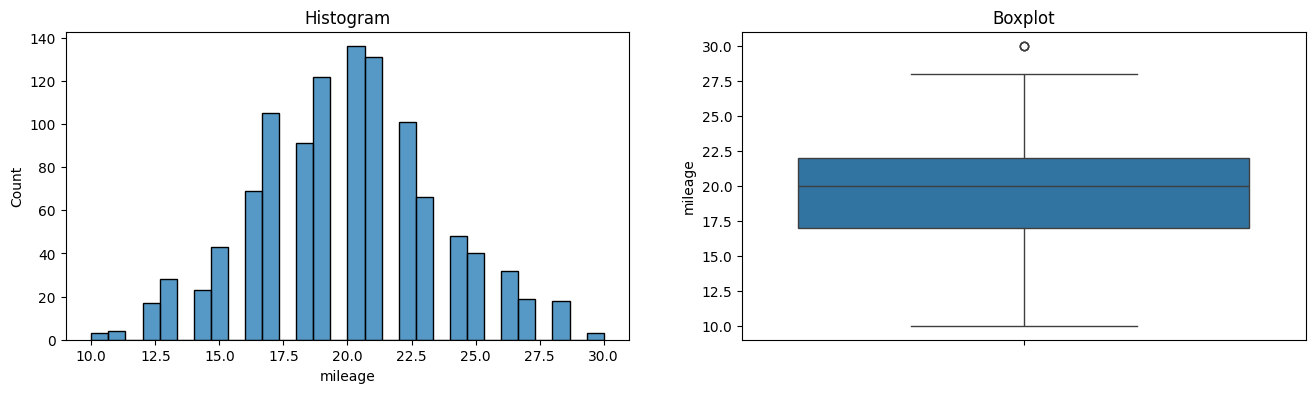

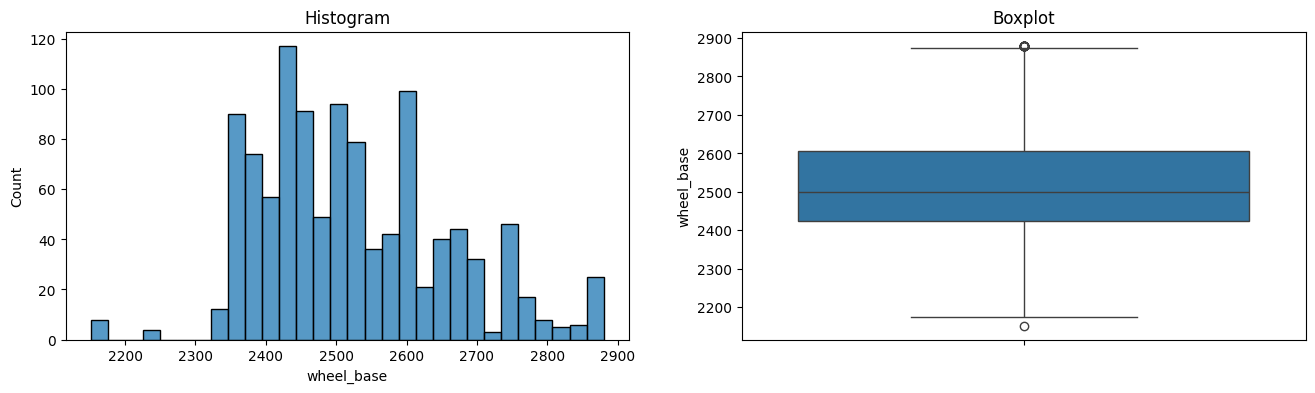

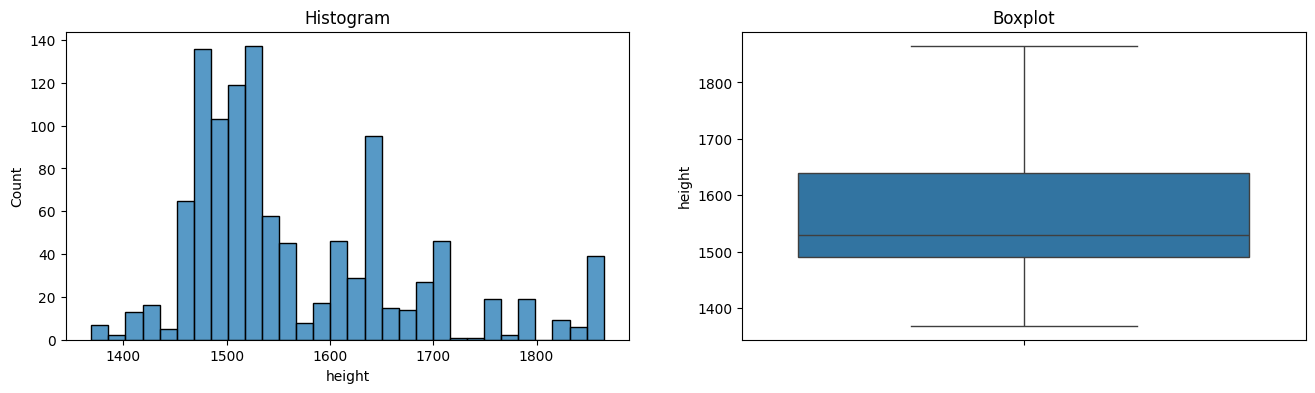

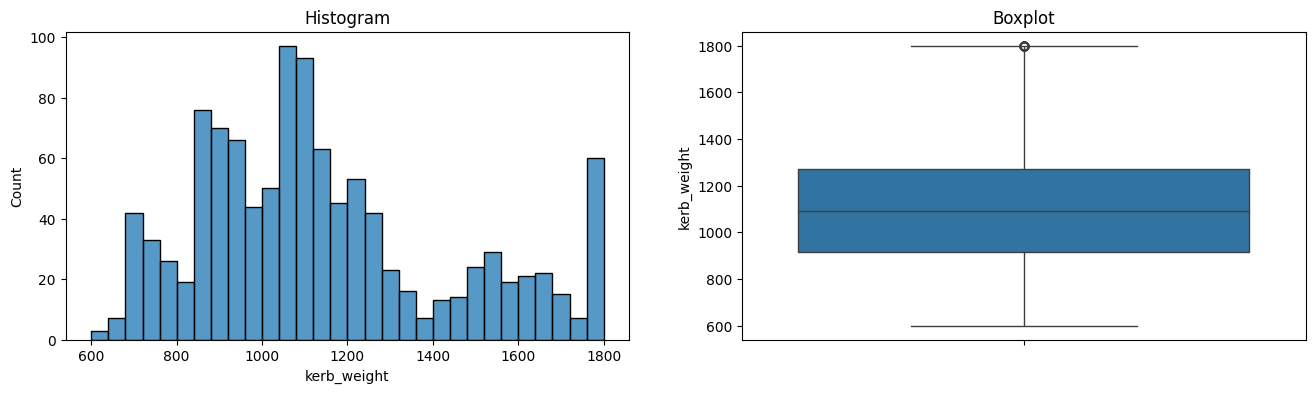

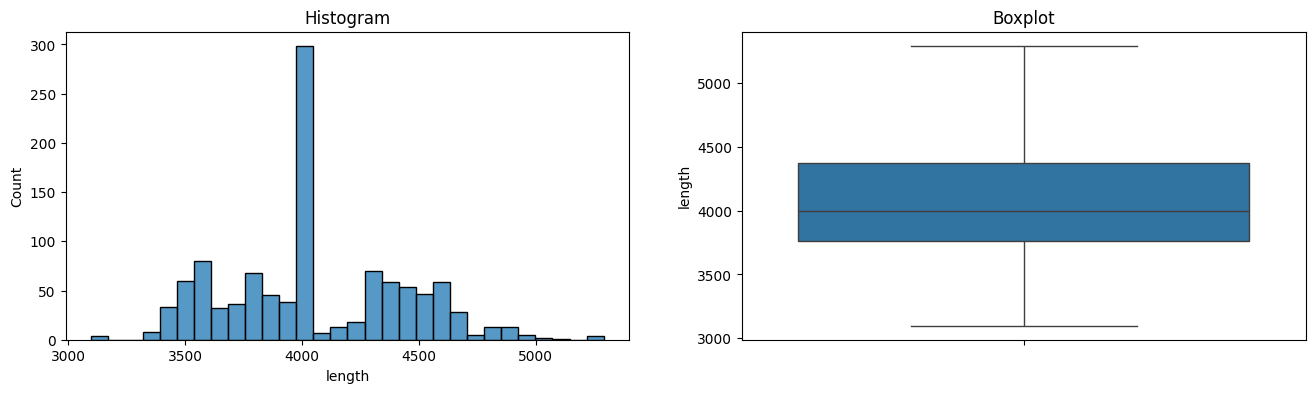

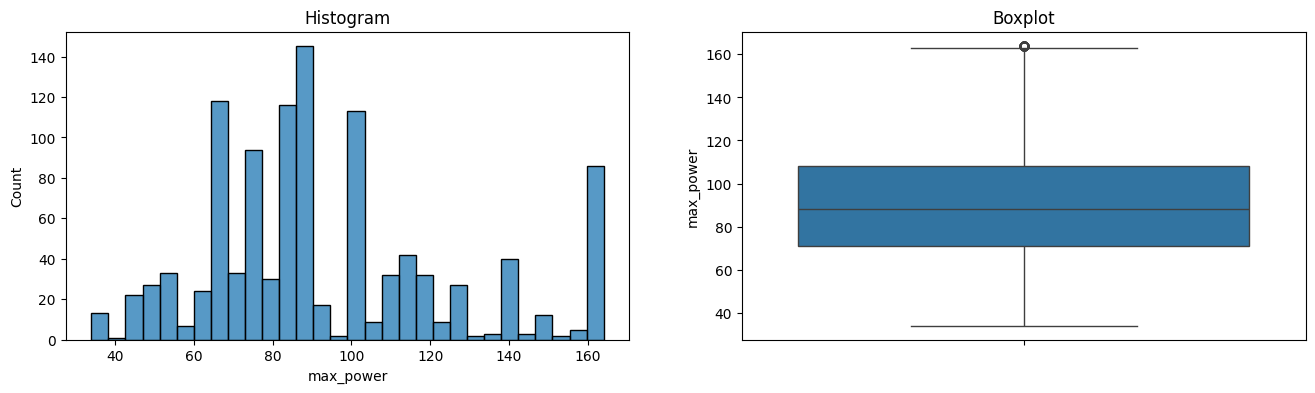

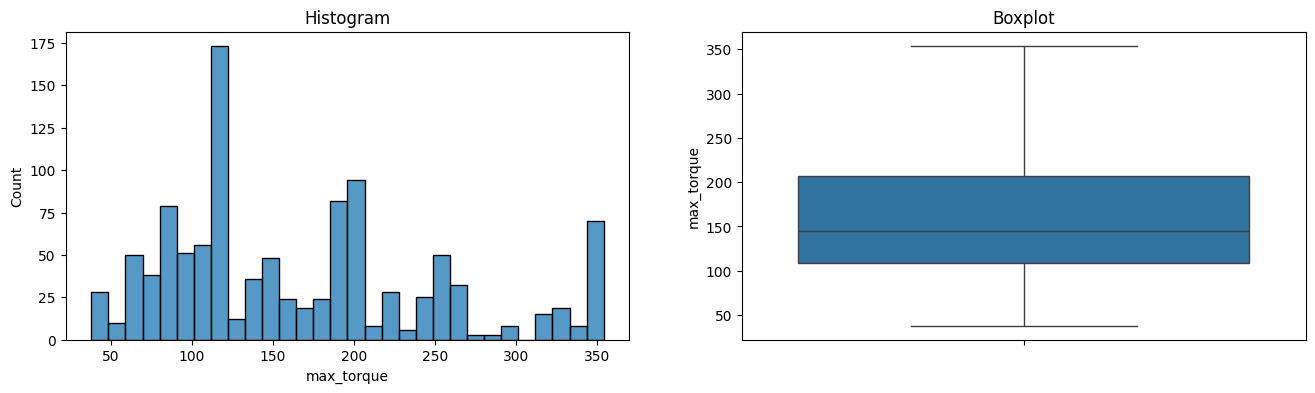

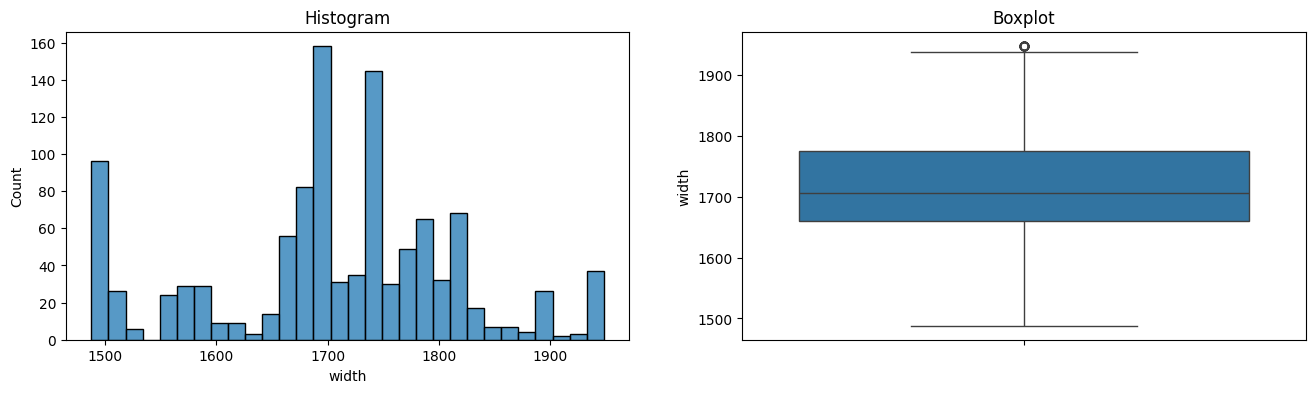

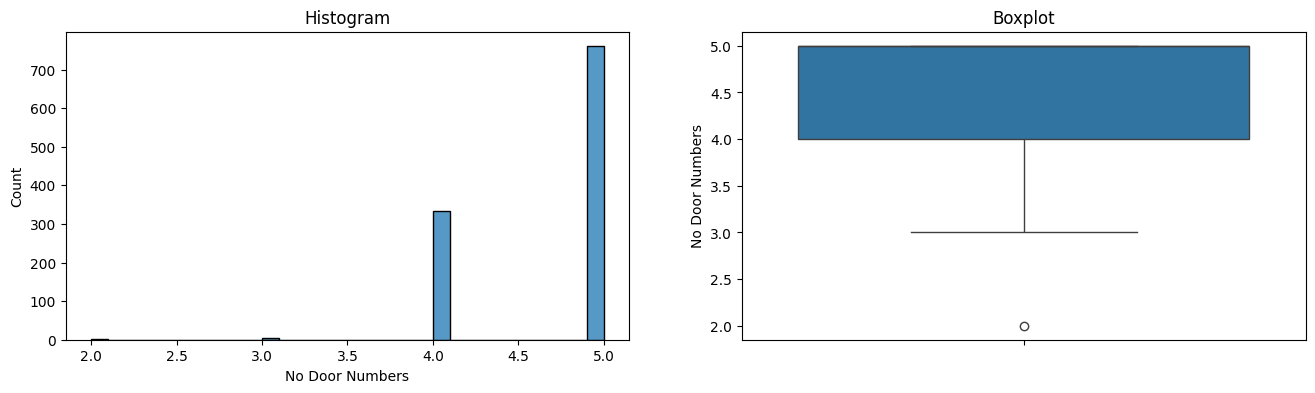

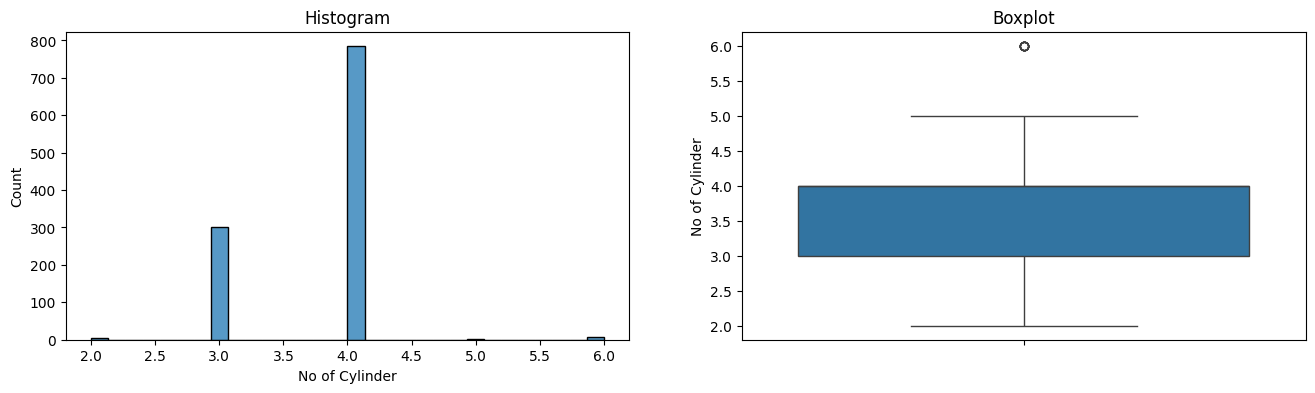

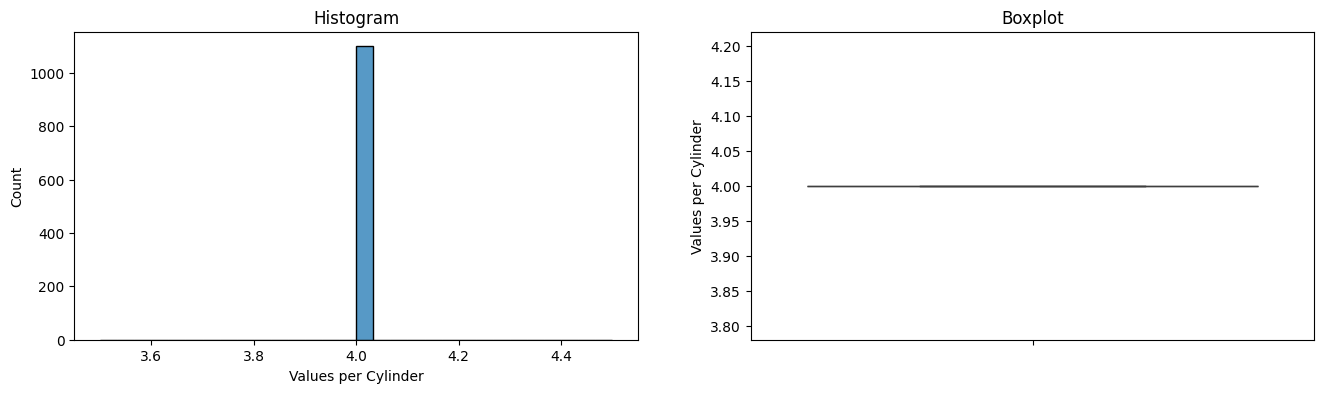

In [104]:
for m in nc:
    plots(df, m)

In [105]:
# for Q-Q plots
import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer

def diagnostic_plots(df, variable):

    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable

    plt.figure(figsize=(15, 6))

    # histogram
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    plt.title(f"Histogram of {variable}")

    # q-q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(f"Q-Q plot of {variable}")

    plt.show()



### Changing the distribution of the 'price_new' and 'kms' columns

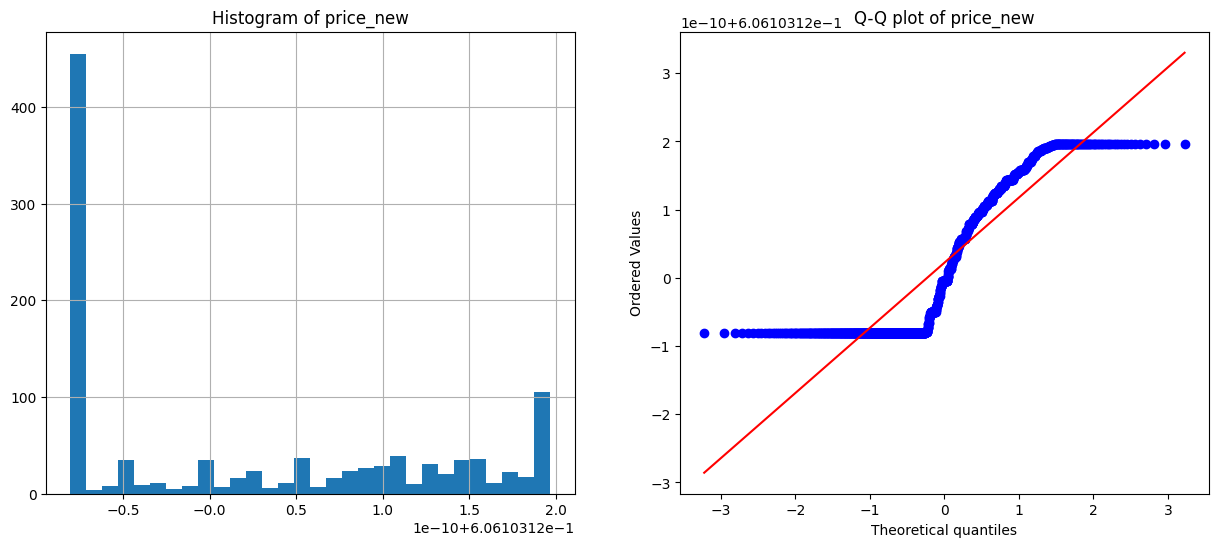

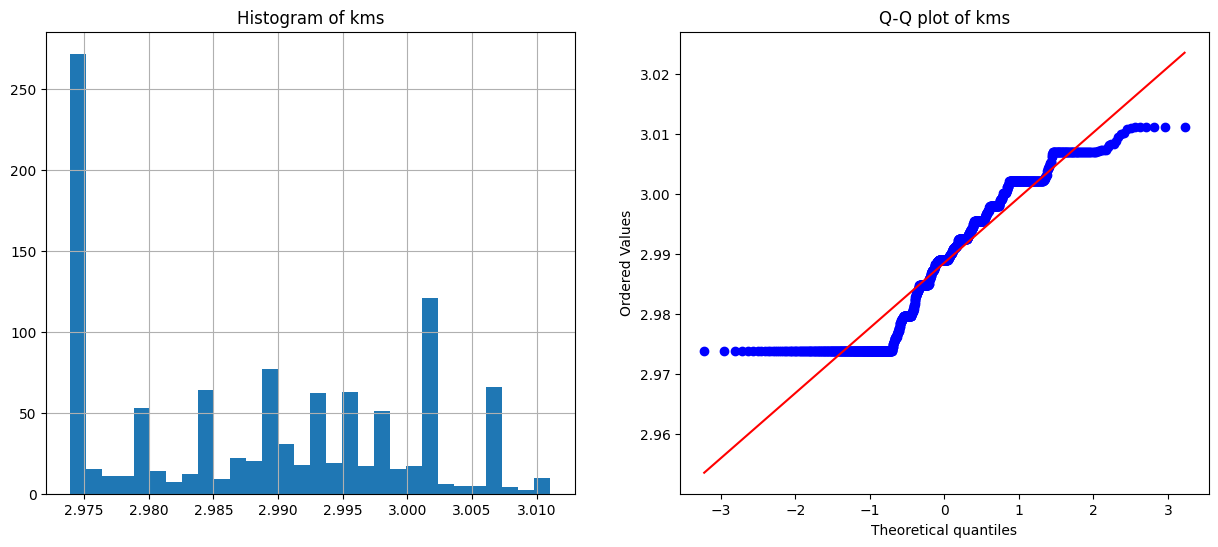

In [106]:
# with open-source packages
from sklearn.preprocessing import PowerTransformer

#transforming the ''price_new' column using "box-cox"
transformer1 = PowerTransformer(method="box-cox", standardize=False)
transformer1.fit(df[['price_new']])
# transformer1.set_output(transform="pandas")
df['price_new']= transformer1.transform(df[['price_new']])

diagnostic_plots(df, 'price_new')

#transforming the 'kms' column using "box-cox"
transformer2 = PowerTransformer(method="box-cox", standardize=False)
transformer2.fit(df[['kms']])
# transformer2.set_output(transform="pandas")
df['kms']= transformer2.transform(df[['kms']])

diagnostic_plots(df, 'kms')

In [107]:
from sklearn.model_selection import train_test_split

# for encoding with feature-engine
from feature_engine.encoding import MeanEncoder

In [108]:
s=new_all_selected_features.index('price_new')
s1=new_all_selected_features[s]

# Removing the 'price_new' column from 'new_all_selected_features' list
new_all_selected_features.pop(s)
new_all_selected_features

['owner',
 'oem',
 'body_type',
 'registration_year',
 'alloy_wheel_size',
 'turbo_charger',
 'front_brake_type',
 'gear_box',
 'Rear Brake Type',
 'seating_capacity',
 'kms',
 'engine_displacement',
 'mileage',
 'wheel_base',
 'height',
 'kerb_weight',
 'length',
 'max_power',
 'max_torque',
 'width',
 'No Door Numbers',
 'No of Cylinder',
 'Values per Cylinder']

In [109]:
y=df[s1]
X=df[new_all_selected_features]


X_train, X_test, y_train, y_test = train_test_split(
    X,  # predictors
    y,  # target
    test_size=0.20,  # percentage of obs in test set
    random_state=0,
)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((879, 23), (220, 23))

In [110]:
mean_enc = MeanEncoder(variables=cc) #cc- categorical columns

In [111]:
mean_enc.fit(X_train, y_train)

MeanEncoder(variables=['owner', 'oem', 'body_type', 'registration_year',
                       'alloy_wheel_size', 'turbo_charger', 'front_brake_type',
                       'gear_box', 'Rear Brake Type', 'seating_capacity'])

In [112]:
X_train = mean_enc.transform(X_train)
X_test = mean_enc.transform(X_test)

# let's explore the result
X_train.head()

C:\Users\Kavin\anaconda3\envs\car_dekho_mlproject\lib\site-packages\feature_engine\encoding\base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) Rear Brake Type.
  warnings.warn(


,owner,oem,body_type,registration_year,alloy_wheel_size,turbo_charger,front_brake_type,gear_box,Rear Brake Type,seating_capacity,...,wheel_base,height,kerb_weight,length,max_power,max_torque,width,No Door Numbers,No of Cylinder,Values per Cylinder
465,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,...,2550.0,1485.0,1100.0,4440.0,116.0,146.0,1695.0,4.0,4.0,4.0
804,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,...,2660.0,1635.0,1800.0,4355.0,164.0,354.0,1948.0,5.0,4.0,4.0
201,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,...,2699.0,1432.0,1570.0,4630.0,136.0,300.0,1777.0,4.0,4.0,4.0
1023,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,...,2600.0,1489.0,1107.0,4549.0,119.0,145.0,1748.0,4.0,4.0,4.0
65,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,0.606103,...,2610.0,1645.0,1540.0,4315.0,113.0,250.0,1800.0,5.0,4.0,4.0


In [113]:
X_test.isnull().sum()

owner                  0
oem                    0
body_type              0
registration_year      0
alloy_wheel_size       0
turbo_charger          0
front_brake_type       0
gear_box               0
Rear Brake Type        3
seating_capacity       0
kms                    0
engine_displacement    0
mileage                0
wheel_base             0
height                 0
kerb_weight            0
length                 0
max_power              0
max_torque             0
width                  0
No Door Numbers        0
No of Cylinder         0
Values per Cylinder    0
dtype: int64

In [114]:
X_test['price_new']=y_test
X_test.dropna(inplace=True)
X_test.isnull().sum()

owner                  0
oem                    0
body_type              0
registration_year      0
alloy_wheel_size       0
turbo_charger          0
front_brake_type       0
gear_box               0
Rear Brake Type        0
seating_capacity       0
kms                    0
engine_displacement    0
mileage                0
wheel_base             0
height                 0
kerb_weight            0
length                 0
max_power              0
max_torque             0
width                  0
No Door Numbers        0
No of Cylinder         0
Values per Cylinder    0
price_new              0
dtype: int64

In [115]:
y_test=X_test['price_new']
X_test=X_test[new_all_selected_features]
X_test.shape

(217, 23)

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

In [117]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [118]:
# Let's train a linear model.

# Instantiate a linear model.
linreg = LinearRegression()

# Train the model.
linreg.fit(scaler.transform(X_train), y_train)

# Make predictions on the train set and calculate
# the mean squared error.
# print('Train set')
pred_train = linreg.predict(scaler.transform(X_train))
print('Linear Regression rmse: {}'.format(np.sqrt(mean_squared_error(y_train, pred_train))))
print('Linear Regression r2-score: {}'.format(r2_score(y_train, pred_train)))
# Make predictions on the test set and calculate
# the mean squared error.
print('Test set')
pred_test = linreg.predict(scaler.transform(X_test))
print('Linear Regression rmse: {}'.format(np.sqrt(mean_squared_error(y_test, pred_test))))
print('Linear Regression r2-score: {}'.format(r2_score(y_test, pred_test)))
print()

Linear Regression rmse: 4.988883028973624e-11
Linear Regression r2-score: 0.7722897355404665
Test set
Linear Regression rmse: 5.320104439347566e-11
Linear Regression r2-score: 0.7509064969359998



In [119]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [120]:
hr=HistGradientBoostingRegressor(learning_rate=0.05,max_leaf_nodes=300,max_depth=100,
                                               max_iter=250,
                                               random_state=2023)
# Train the model.
hr.fit(scaler.fit_transform(X_train), y_train)

# Make predictions on the train set and calculate
# the mean squared error.
print('Train set')
pred_train = hr.predict(scaler.transform(X_train))
print('HistGradientBoostingRegressor rmse: {}'.format(np.sqrt(mean_squared_error(y_train, pred_train))))
print('HistGradientBoostingRegressor r2-score: {}'.format(r2_score(y_train, pred_train)))
# Make predictions on the test set and calculate
# the mean squared error.
print('Test set')
pred_test = hr.predict(scaler.transform(X_test))
print('HistGradientBoostingRegressor rmse: {}'.format(np.sqrt(mean_squared_error(y_test, pred_test))))
print('HistGradientBoostingRegressor r2-score: {}'.format(r2_score(y_test, pred_test)))
print()

Train set
HistGradientBoostingRegressor rmse: 1.3733923702840022e-11
HistGradientBoostingRegressor r2-score: 0.9827430029215012
Test set
HistGradientBoostingRegressor rmse: 3.293457490038742e-11
HistGradientBoostingRegressor r2-score: 0.9045389496431545



### Inverse transforming the target column and comparing the 'actual' and 'predicted' values

In [121]:
u1=pd.concat([y_train,y_test],axis=0)
u2=pd.concat([pd.Series(pred_train),pd.Series(pred_test)],axis=0)

pred=transformer1.inverse_transform(pd.DataFrame(u2,columns=['price_new']))
y= transformer1.inverse_transform(u1.values.reshape(-1, 1))
x=pd.DataFrame({'rv':list(y),'pv':list(pred)})
x['residuals']=(x['rv']-x['pv'])
x['error']=(((x['rv']-x['pv']))/(x['rv']))

x['residuals_cor']=[i[0] for i in x['residuals']]
x['error_cor']=[i[0] for i in x['error']]
x.head()

C:\Users\Kavin\anaconda3\envs\car_dekho_mlproject\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


,rv,pv,residuals,error,residuals_cor,error_cor
0,[423499.9570614073],[441454.1740347915],[-17954.216973384202],[-0.042394849572041045],-17954.216973,-0.042395
1,[1528501.6048829134],[1485429.135217659],[43072.469665254466],[0.028179538397379644],43072.469665,0.028180
2,[1528501.6048829134],[1342735.3582599661],[185766.24662294728],[0.12153487181793138],185766.246623,0.121535
3,[1524998.6380418018],[1313190.784243895],[211807.85379790678],[0.1388905199744191],211807.853798,0.138891
4,[1528501.6048829134],[1563363.624685316],[-34862.019802402705],[-0.02280797068909405],-34862.019802,-0.022808


In [122]:
x['residuals'].max(),x['residuals'].min()

(array([601063.7705264]), array([-2335472.27270812]))

In [123]:
round(list(x['error'].max())[0],2),round(list(x['error'].min())[0],2)

(0.48, -1.8)

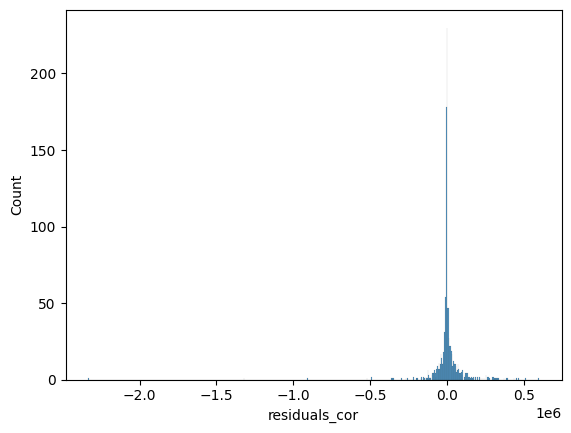

In [124]:
sns.histplot(x['residuals_cor'])
plt.show()

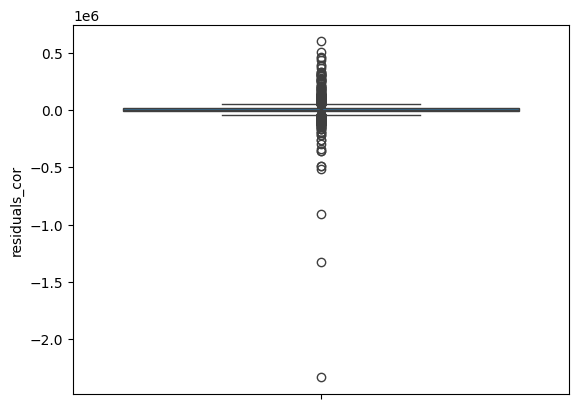

In [125]:
sns.boxplot(x['residuals_cor'])
plt.show()

In [126]:
x['residuals_cor'].describe()

count    1.096000e+03
mean     4.925610e+03
std      1.178870e+05
min     -2.335472e+06
25%     -7.594626e+03
50%      3.631416e+02
75%      1.540909e+04
max      6.010638e+05
Name: residuals_cor, dtype: float64

### I hypertuned the histgradientboostingregressor model for this dataset alone 

### From 248 features ,through various analysis and tests I used only 23 features to predict the 'price' of the cars.Hope the project results are good!!! 